<a href="https://colab.research.google.com/github/StetskoSergey/algotrade/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_5_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B9_%D1%86%D0%B5%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # библиотека нампи
import pandas as pd # библиотека пандас
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
import tensorflow as tf           # библиотека машинного обучения

# Графики с библиотекой mplfinance
Расширение библиотеки  matplotlib для работы и построения графиков из датасетов 

In [ ]:
!pip install --upgrade mplfinance -q
import mplfinance as mpf  # библиотека для отрисовки OHCL
clear_output()

# **Данные с yfinance**

[документация](https://pypi.org/project/yfinance/)

In [ ]:
!pip install yfinance -q
#!conda install -c ranaroussi yfinance --y
import yfinance as yf # requires yfinance - pip install yfinance
clear_output()

## 500 известных компаний с Wikipedia


Внимание - выбор случайного тикера может быть закомментирован

In [ ]:
# публичный список 500 известных компаний с Wikipedia
df_wiki = pd.read_html("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

# случайный индекс 
idx = np.random.choice(df_wiki.index)
# тикер и компания по случайному индексу 
tiker  = df_wiki.loc[idx].Symbol
#tiker  = 'LKQ'
company = df_wiki.loc[idx].Security   
#company = 'LKQ Corporation'
print(f'Берем данные по случайному тикеру {tiker} комании - {company}')    

Берем данные по случайному тикеру SPGI комании - S&P Global


In [ ]:
# определяем параметры датасета
interval = "1d"
start = '2010-01-01'
stock = tiker
end = '2022-12-24'

# загружаем по тикеру и параметрам 
df_tiker = yf.download(stock, start=start, end=end,  interval=interval, actions=False)
print(df_tiker.shape)
df_tiker.head()


[*********************100%***********************]  1 of 1 completed
(3268, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,33.919998,33.919998,33.380001,33.610001,26.362896,1572200
2010-01-05,33.490002,33.639999,33.320000,33.639999,26.386414,1443400
2010-01-06,33.400002,33.599998,33.200001,33.340000,26.151106,1328300
2010-01-07,33.360001,34.119999,33.259998,34.080002,26.731541,2010700
2010-01-08,33.939999,34.060001,33.610001,33.950001,26.629568,1075400


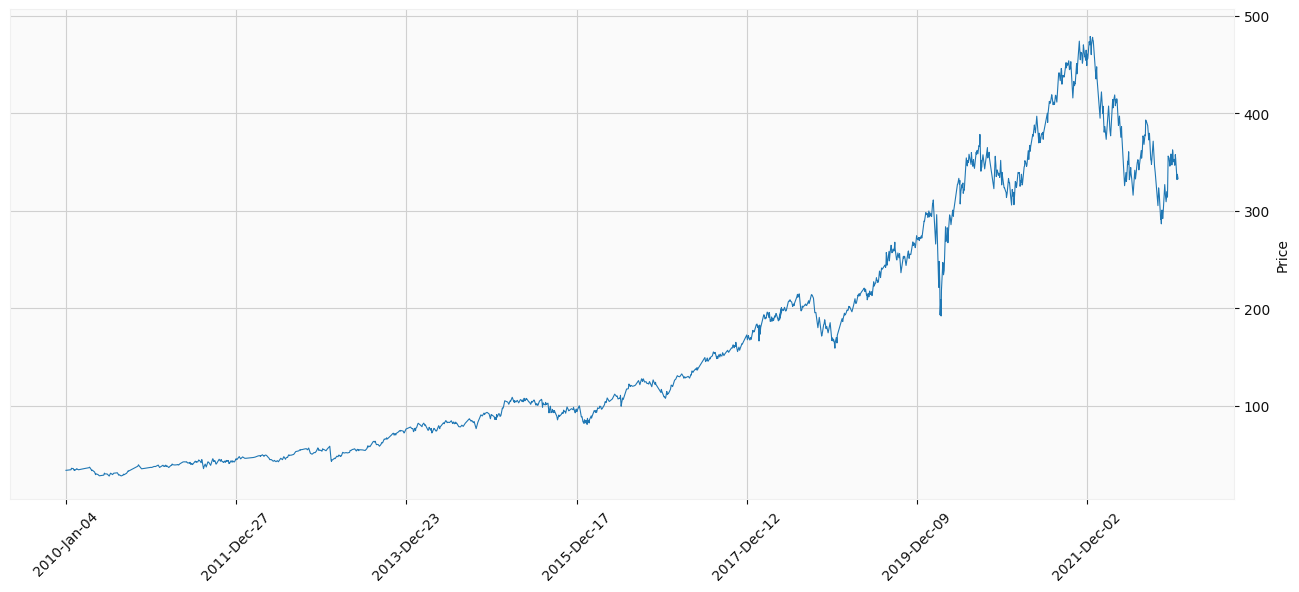

In [ ]:
# отрисовываем график с mplfinance
mpf.plot(df_tiker, style= 'yahoo', type='line', figsize = (17, 7));

## Добавим SMA


In [ ]:
def add_sma(df: pd.DataFrame, windows:list, indicators: list):
    """ 
    data - типа OHCL
    Returns a pd.Series sma.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_SMA_{window}'] = copy[col].rolling(window = window).mean()
    return copy

def add_diff(df: pd.DataFrame, depth: int, indicators: list, only_indicators = False):
    """
    df - DataFrame df типа OHCL
    depth - глубина сбора производных
    Returns a DataFrame with the vwap.
    """
    copy = df.copy() if not only_indicators else df[indicators].copy()
    # Расчет индикаторов относительной доходности
    for i in range(1, depth + 1):
        indicators_changes = [f'{ind}_diff_{i}' for ind in indicators]
        # Относительная доходность в сотых долях за период i шагов назад
        for indicator_change, indicator in zip(indicators_changes, indicators):
          copy[indicator_change] = copy[indicator].diff(periods=i)
    return copy

def add_ema(df: pd.DataFrame, windows:list, indicators: list):
    """ 
    data - типа df.Close
    Returns a pd.Series ema.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_EMA_{window}'] = copy[col].ewm(span=window).mean()

    return copy

def add_macd(df: pd.DataFrame, indicators: list):
    """
    data - типа DataFrame
    Returns a pd.Series with the MACD.
    """
    copy = df.copy()
    for col in indicators:
      exp1 = copy[col].ewm(span=12, adjust=False).mean()
      exp2 = copy[col].ewm(span=26, adjust=False).mean()
      copy[f'{col}_MACD'] = exp1 - exp2
    return copy


def make_data(df:pd.DataFrame, depth: int, windows:list, 
              use_columns:list, rolls:list):
    copy = df.copy()
    # набираем мз чего дополняем данные
    copy = add_diff(copy, depth, use_columns, only_indicators = False)
    copy = add_ema(copy, windows,indicators = use_columns)
    copy = add_sma(copy, windows,indicators = use_columns)
    copy = add_macd(copy, indicators = use_columns)
    # оставляем use_columns и их производные 
    features = list(filter(lambda x: x.split('_')[0] in use_columns, copy.columns))
    return copy[features]


def add_from_datetime(df:pd.DataFrame):
    copy = df.copy()
    # делаем еще колонки на основе даты 
    day  =  1+copy.index.day                      # день месяца 
    week_day =  1+copy.index.dayofweek            # день недели  
    week  = 1+copy.index.isocalendar()['week']    # недели года
    month  = 1+copy.index.month                   # месяц  
    year  =  1+copy.index.year                    # год 
    dayofyear =1+copy.index.dayofyear             # день года
    mix_day = day*week_day*month*year*dayofyear*week
    copy['Mix_day'] = np.log(mix_day).to_numpy()
    return copy

In [ ]:
# обогощаем датасет на основе функци индикаторов 
FEATURES =  ['Open', 'High','Low', 'Close'] #, 'Adj Close'
DIFFBACK = 7
SET_WIND = [3, 7]
ROLLS = [5, 10]
df_data = make_data(df_tiker, DIFFBACK, SET_WIND, FEATURES, ROLLS)
df_data = add_from_datetime(df_data)

In [ ]:
# переводим Volume в Log_Volume в df_data
df_data['Log_Volume'] = np.log(df_tiker['Volume'])

In [ ]:
# параметр, который будем предсказывать
WIND_SMA = 12
use_column = 'Close'
PRED_PRICE = f'{use_column}_SMA_{WIND_SMA}'
print(f'Предсказывать будем цену - {PRED_PRICE}')

# добавляем колонку Close_SMA_12
df_data = add_sma(df_data, [WIND_SMA], [use_column])
# Удаление строк с неполными данными
df_data.dropna(inplace=True)
print(df_data.shape)

Предсказывать будем цену - Close_SMA_12
(3257, 55)


In [ ]:
df_data.head()

,Open,High,Low,Close,Open_diff_1,High_diff_1,Low_diff_1,Close_diff_1,Open_diff_2,High_diff_2,...,High_SMA_7,Low_SMA_7,Close_SMA_7,Open_MACD,High_MACD,Low_MACD,Close_MACD,Mix_day,Log_Volume,Close_SMA_12
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,33.099998,33.750000,33.049999,33.680000,-0.040001,0.150002,0.259998,0.230000,-0.230003,0.049999,...,33.724286,33.127143,33.441429,-0.174659,-0.062132,-0.091791,-0.038957,16.873486,14.327316,33.559167
2010-01-21,33.779999,34.150002,33.250000,33.340000,0.680000,0.400002,0.200001,-0.340000,0.639999,0.550003,...,33.722858,33.082857,33.381429,-0.136433,-0.026687,-0.078534,-0.050918,17.254208,14.190448,33.536667
2010-01-22,33.220001,33.529999,33.020000,33.259998,-0.559998,-0.620003,-0.230000,-0.080002,0.120003,-0.220001,...,33.705715,33.062857,33.382857,-0.149602,-0.048071,-0.085601,-0.066090,17.566255,14.689812,33.505000
2010-01-25,33.549999,33.549999,33.169998,33.400002,0.329998,0.020000,0.149998,0.140003,-0.230000,-0.600002,...,33.681429,33.074286,33.385714,-0.131890,-0.062682,-0.078196,-0.066055,16.425166,14.417145,33.510000
2010-01-26,33.400002,34.619999,32.680000,34.230000,-0.149998,1.070000,-0.489998,0.829998,0.180000,1.090000,...,33.842857,33.000000,33.512857,-0.128475,0.011942,-0.110591,0.000935,17.193793,14.847092,33.522500


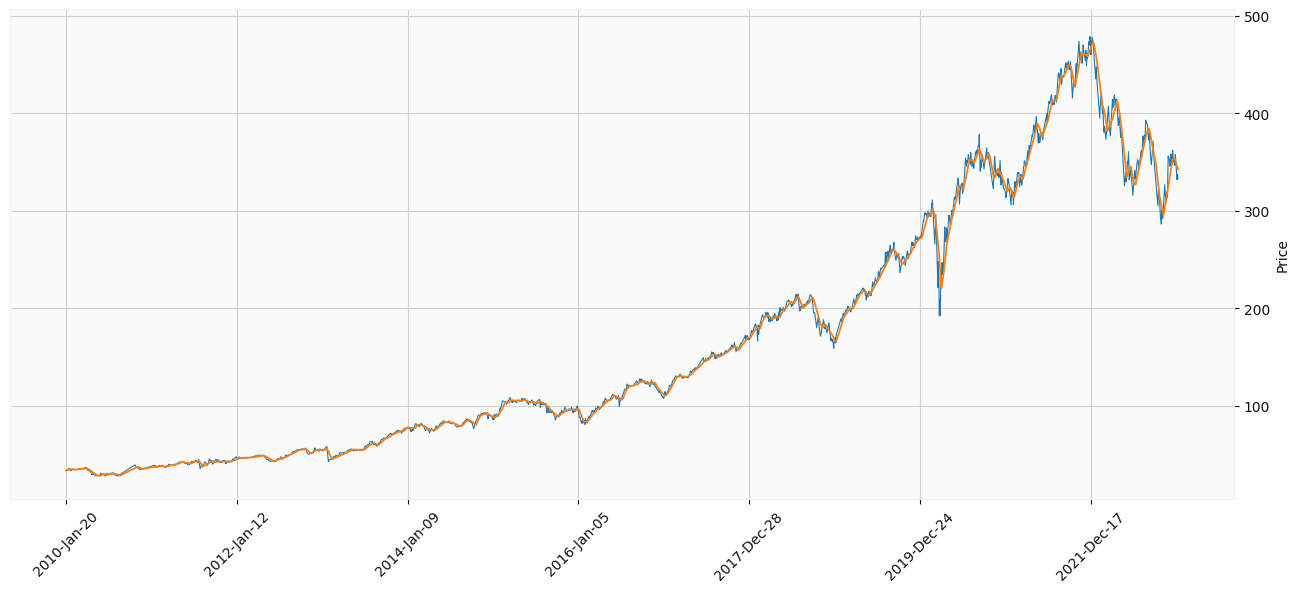

In [ ]:
# отрисовываем график Close с добавленным графиком по колонке df_data[PRED_PRICE]
mpf.plot(df_data,  # датафрейм
         addplot= (mpf.make_addplot(df_data[PRED_PRICE])), # добавленый график df_data[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));

## Делим на Tain и Test


Учебный датасет


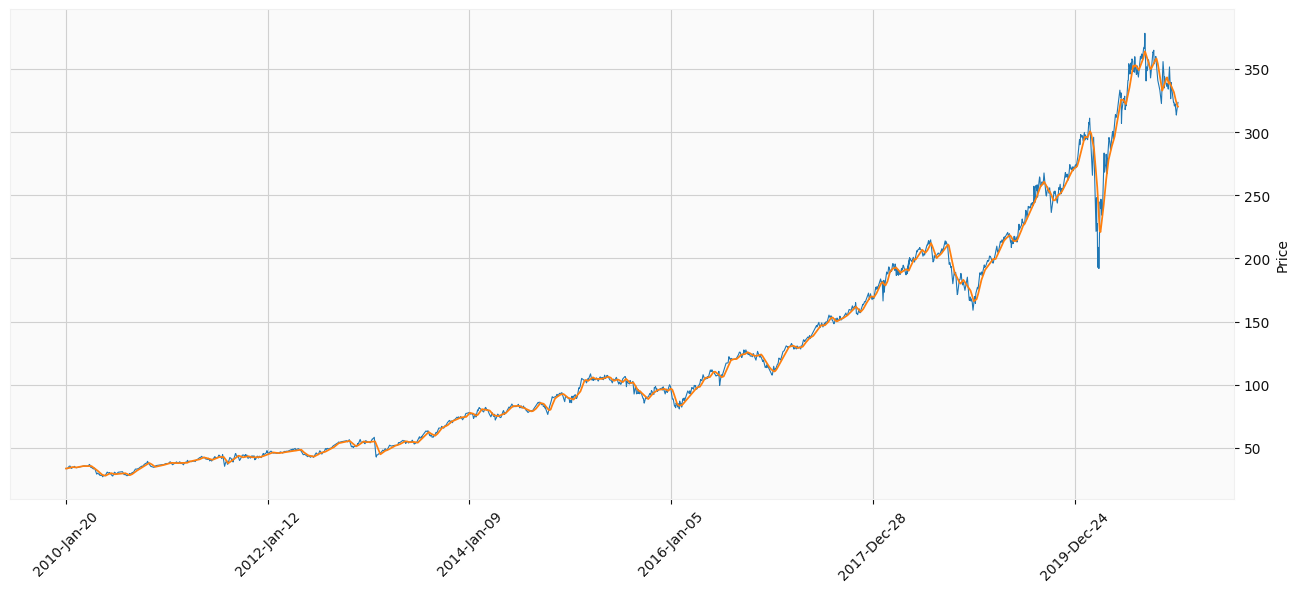

Тестовый датасет


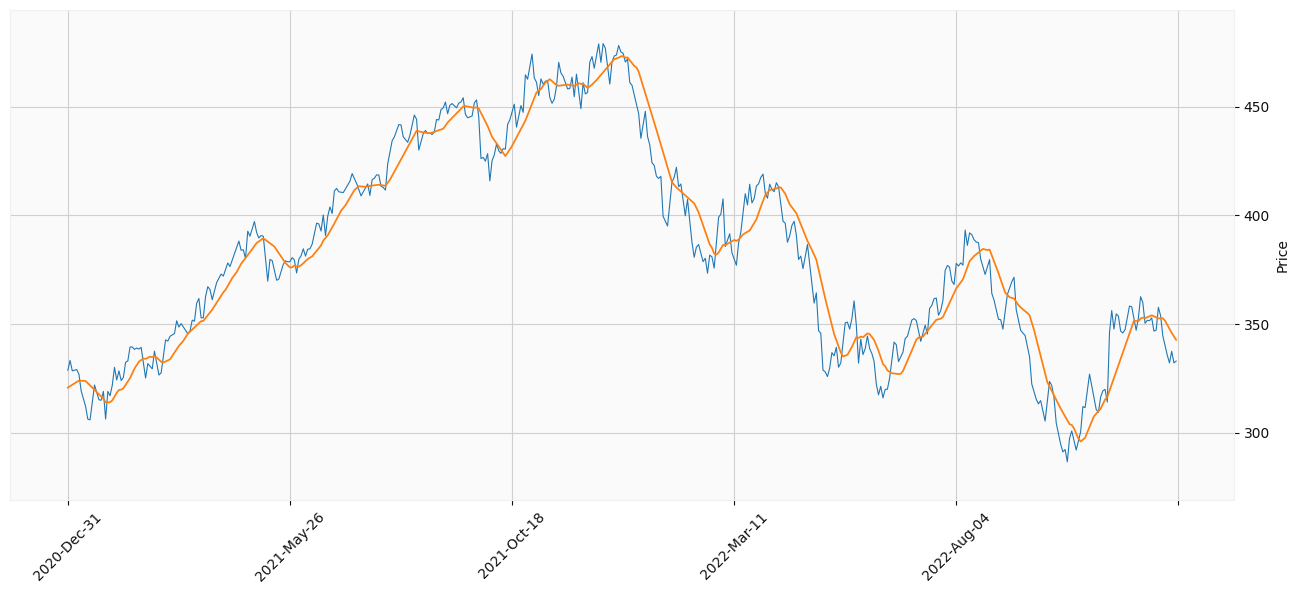

In [ ]:
test_size = 500 # для теста откусим последние test_size значений
# Тренировочная выборка
print(f'Учебный датасет')
df_train = df_data[:-test_size]

# отрисовываем график Close с добавленным графиком по колонке df_train[PRED_PRICE]
mpf.plot(df_train,  # датафрейм
         addplot= (mpf.make_addplot(df_train[PRED_PRICE])), # добавленый график df_train[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
df_test = df_data[-test_size:] 

# отрисовываем график Close с добавленным графиком по колонке df_test[PRED_PRICE]
mpf.plot(df_test,  # датафрейм
         addplot= (mpf.make_addplot(df_test[PRED_PRICE])), # добавленый график df_test[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


## Подготовка данных для обучения

### Деление на TRAIN и VAL части

Предсказывать будем на 5ть шагов

In [ ]:
df_train.columns[:-1]

Index(['Open', 'High', 'Low', 'Close', 'Open_diff_1', 'High_diff_1',
       'Low_diff_1', 'Close_diff_1', 'Open_diff_2', 'High_diff_2',
       'Low_diff_2', 'Close_diff_2', 'Open_diff_3', 'High_diff_3',
       'Low_diff_3', 'Close_diff_3', 'Open_diff_4', 'High_diff_4',
       'Low_diff_4', 'Close_diff_4', 'Open_diff_5', 'High_diff_5',
       'Low_diff_5', 'Close_diff_5', 'Open_diff_6', 'High_diff_6',
       'Low_diff_6', 'Close_diff_6', 'Open_diff_7', 'High_diff_7',
       'Low_diff_7', 'Close_diff_7', 'Open_EMA_3', 'High_EMA_3', 'Low_EMA_3',
       'Close_EMA_3', 'Open_EMA_7', 'High_EMA_7', 'Low_EMA_7', 'Close_EMA_7',
       'Open_SMA_3', 'High_SMA_3', 'Low_SMA_3', 'Close_SMA_3', 'Open_SMA_7',
       'High_SMA_7', 'Low_SMA_7', 'Close_SMA_7', 'Open_MACD', 'High_MACD',
       'Low_MACD', 'Close_MACD', 'Mix_day', 'Log_Volume'],
      dtype='object')

In [ ]:
# Формируем параметры загрузки данных
DEPTH = 29                               # Анализируем по 29 прошедшим точкам 
VAL_LEN = 500                            # Используем 300 записей для проверки
PREDICT_LAG = 5                          # на сколько шагов вперед       
TRAIN_LEN = df_train.shape[0] - VAL_LEN  # Размер тренировочной выборки
TRAIN_COLUMNS = df_train.columns[:-1]    # колонки для тренировочной выборки

# Делим данные на тренировочную и тестовую выборки 
x_train, x_val = df_train[TRAIN_COLUMNS][:TRAIN_LEN - PREDICT_LAG + 1], \
                 df_train[TRAIN_COLUMNS][TRAIN_LEN + DEPTH + 2:-PREDICT_LAG + 1]

x_train.shape, x_val.shape              

((2253, 54), (465, 54))

In [ ]:
# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() # 
X_SCAILER.fit(x_train)                  # обучаем X_SCAILER
x_train = X_SCAILER.transform(x_train)  # трансформируем x_train
x_val = X_SCAILER.transform(x_val)      # трансформируем x_val

x_train[0], x_val[0]

(array([0.03179859, 0.03134565, 0.03275343, 0.03547081, 0.44324102,
        0.53823737, 0.58785019, 0.45584035, 0.47365168, 0.59358782,
        0.59068618, 0.50328431, 0.49607089, 0.56109624, 0.57137961,
        0.60808294, 0.54366608, 0.58559438, 0.58598026, 0.58928552,
        0.54648351, 0.5640421 , 0.53629138, 0.55366061, 0.52710913,
        0.60916194, 0.53063383, 0.52345619, 0.45425469, 0.58769919,
        0.52622539, 0.48727182, 0.03054104, 0.03052208, 0.03160569,
        0.03219366, 0.03054967, 0.02987909, 0.03134876, 0.03112285,
        0.03085771, 0.03046289, 0.03121909, 0.03147123, 0.03142532,
        0.03017146, 0.03180341, 0.03100166, 0.61077476, 0.61324857,
        0.6165639 , 0.62059588, 0.38249554, 0.3895657 ]),
 array([0.90455165, 0.91920846, 0.923271  , 0.9312953 , 0.51022823,
        0.73146588, 0.66448551, 0.59829092, 0.51186423, 0.75813263,
        0.66299014, 0.6099468 , 0.54780614, 0.69166349, 0.6297183 ,
        0.75231767, 0.60059571, 0.68542671, 0.64978075, 0.

In [ ]:
# Функция разделения набора данных на выборки для обучения нейросети 
# x_data - набор входных данных
# predict_lag - количество шагов в будущее для предсказания
def future_sequence(x_data, predict_lag):
    # Определение максимального индекса
    y_len = x_data.shape[0] - (predict_lag - 1)
    # отстоящих на predict_lag шагов вперед
    y = [x_data[i:i+ predict_lag] for i in range(y_len)] 
    # Возврат результатов в виде массивов numpy
    return np.array(y)

In [ ]:
# Для подготовки yTrain на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
# Для таргета берем колонку PRED_PRICE
y_train = future_sequence(df_train[PRED_PRICE][:TRAIN_LEN], PREDICT_LAG)
y_val =  future_sequence(df_train[PRED_PRICE][TRAIN_LEN + DEPTH + 2:], PREDICT_LAG)

# делаем ли np.log для у
MAKE_LOG = True
if MAKE_LOG:
  y_train = np.log(y_train)  # заменяем  y_train на log(y_train)
  y_val = np.log(y_val)      # заменяем  y_val на log(y_val)

print(y_train.shape, y_val.shape)
y_train[0], y_val[0]

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Y_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() # 
Y_SCAILER.fit(y_train)                    # обучаем Y_SCAILER
y_train = Y_SCAILER.transform(y_train)    # трансформируем y_train
y_val = Y_SCAILER.transform(y_val)        # трансформируем y_val

y_train[0], y_val[0]

(array([0.09137599, 0.09104549, 0.09057997, 0.0906535 , 0.09083728]),
 array([0.96228611, 0.96416129, 0.9655085 , 0.96719357, 0.96848301]))

### Формируем генератор данных TimeseriesGenerator
- https://ru-keras.com/sequence-preprocessing/
- https://keras.io/api/preprocessing/timeseries/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

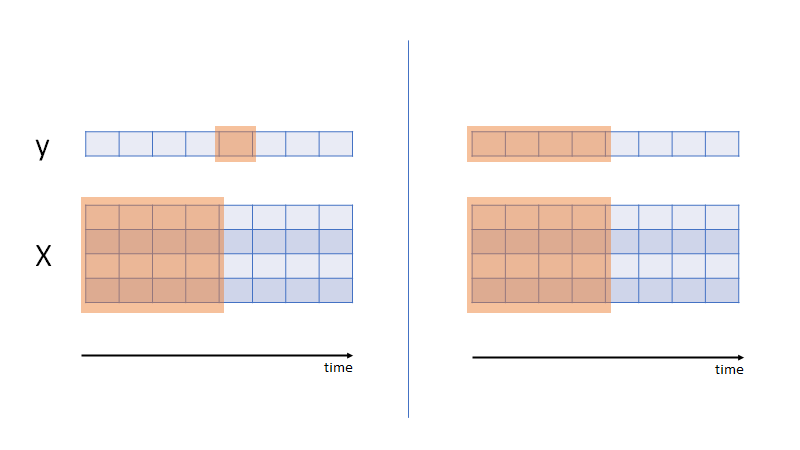

In [ ]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator 

In [ ]:
BATCH_SIZE = 20
# Создаем генератор для обучения
train_datagen = TSG(x_train, y_train,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам 
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val, y_val,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам 
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

In [ ]:
print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]
INSHAPE

(20, 29, 54) (20, 5)


(29, 54)

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val, y_val,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам 
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

(436, 29, 54) (436, 5)


# Формируем сети вручную 

Варианты опробованных моделей

    base_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = INSHAPE,
                            dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.LSTM(units = 50, return_sequences = True,
                            dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.LSTM(units = 50, return_sequences = True,
                            dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.LSTM(units = 50, return_sequences = False,
                            dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(units = 50, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units = PREDICT_LAG, activation='linear')
    ])

  ________________________________
    layer = tf.keras.layers
    def convs(x, n, f, rate, ln = False):
      x = layer.Conv1D(n, f, padding = "causal",
                      dilation_rate = rate,
                      activation="sigmoid")(x)
      x = layer.LayerNormalization()(x) if ln else x
      return x   

    inputs = layer.Input(shape =INSHAPE)
    print('inputs.shape', inputs.shape)
    nerons = 128
    frame = 4
    x = convs(x = inputs, n = nerons,  f = frame, rate = 2, ln = True)
    print('x.shape', x.shape)
    y = convs(x = inputs, n = nerons, f = frame, rate = 4, ln = True)
    print('y.shape', y.shape)
    u = convs(x = inputs, n = nerons, f = frame, rate = 8, ln = True)
    print('u.shape', u.shape)
    v = convs(x = inputs, n = nerons, f = frame, rate = 16, ln = True)
    print('v.shape', v.shape)

    z = layer.concatenate([inputs, x, y, u, v], axis = -1)
    print('z.shape', z.shape)
    z = layer.Activation("sigmoid")(z)
    z = layer.Dropout(0.3)(z)
    z = layer.LayerNormalization()(z)
    # Одномерная свертка
    out = layer.Conv1D(DEPTH, frame, padding="causal", activation="sigmoid")(z)
    out = layer.Flatten()(out)
    out = layer.Dropout(0.2)(out)
    out = layer.Dense(PREDICT_LAG, activation='linear')(out)
    base_model = tf.keras.Model(inputs = inputs, outputs = out)
__________________

In [ ]:
lay = tf.keras.layers

# Входной слой
input = lay.Input(shape =INSHAPE)
# Преобразование в одномерный вектор
x = lay.Flatten()(input)
# Повтор вектора несколько раз
x = lay.RepeatVector(4)(x)
# Одномерная свертка
x = lay.Conv1D(DEPTH * 4, 4, padding='same')(x)
x = lay.LeakyReLU(alpha=0.3)(x)
# Макспулинг и понижение размерности
x = lay.MaxPooling1D(pool_size=4)(x)
# Преобразование в одномерный вектор
x = lay.Flatten()(x)
x = lay.LayerNormalization()(x)
# Повтор вектора несколько раз
x = lay.RepeatVector(2)(x)
# Одномерная свертка
x = lay.Conv1D(DEPTH*2, 2, padding='same')(x)
x = lay.LeakyReLU(alpha=0.3)(x)
# Макспулинг и понижение размерности
x = lay.MaxPooling1D(pool_size=2)(x)
# Преобразование в одномерный вектор
x = lay.Flatten()(x)
x = lay.LayerNormalization()(x)
# Полносвязный слой
x = lay.Dense(DEPTH)(x)
x = lay.LeakyReLU(alpha=0.3)(x)
# Слой регуляризации
x = lay.Dropout(0.3)(x)
# Финальный слой классификатора
x = lay.Dense(PREDICT_LAG, activation='linear')(x)

# Сборка модели из входа и выхода
base_model = tf.keras.Model(input, x)

In [ ]:
print(base_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 1566)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 4, 1566)          0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 4, 116)            726740    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 116)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 116)           0         
 )                                                           

## Обучение модели

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.MSE
base_model.compile(optimizer = optimizer, loss = loss)

# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.7, 
                                                 patience = 3,
                                                 min_lr = 1e-9, verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [ ]:
from time import time
start = time()
history = base_model.fit(train_datagen,          # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 50,
                          batch_size = 32,
                          callbacks=[early_stopping, reduce_lr],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/50
112/112 [==============================] - 5s 28ms/step - loss: 0.1578 - val_loss: 0.0152 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 4s 32ms/step - loss: 0.0239 - val_loss: 0.0451 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 5s 47ms/step - loss: 0.0200 - val_loss: 0.0128 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 6s 49ms/step - loss: 0.0188 - val_loss: 0.0099 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 5s 45ms/step - loss: 0.0149 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 4s 39ms/step - loss: 0.0138 - val_loss: 0.0174 - lr: 0.0010
Epoch 7/50
112/112 [==============================] - 4s 39ms/step - loss: 0.0117 - val_loss: 0.0314 - lr: 0.0010
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
112/112 [==============================] - 3s 25m

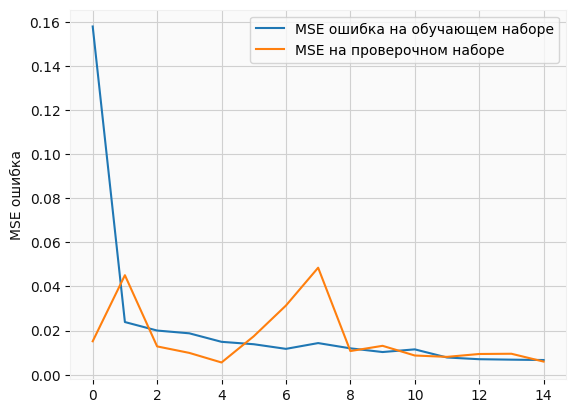

In [ ]:
plt.plot(history.history['loss'], 
         label='MSE ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='MSE на проверочном наборе')
plt.ylabel('MSE ошибка')
plt.legend()
plt.show()

## Функции для оценки и отрисовки автокорреляции

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
def get_scalepred(model: object, x: list, y: list, у_scaler: object):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (model) и проверочную выборку
  Выдаёт результаты предсказания y_pred
  И правильные ответы в исходной размерности y_true (какими они были до нормирования)
  model - нейронная сеть
  x - x данные для предикта
  y - y проверочные данные
  у_scaler - ранее обученный скэйлер для y

  '''
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  y_pred = у_scaler.inverse_transform(model.predict(x))
  y_true = у_scaler.inverse_transform(y)
  if MAKE_LOG:
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
  return (y_pred, y_true)


# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def show_predict(start: int, finish: int, pred_lags: int,
                 y_pred: list, y_true: list, name: str, figsize=(25,10)):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  finish - длина графика, которую отрисовываем
  pred_lags - какие шаги предсказания отрисовываем
  y_pred - предсказания модели
  y_true - верные ответы
  name - имя предсказания 
  '''
  plt.figure(figsize=(figsize))
  for lag in pred_lags:
      plt.plot(y_pred[start:start+finish, lag], 
              label=f'Прогноз на {lag+1}й шаг')
      plt.plot(y_true[start:start+finish, lag], 
              label=f'Базовый ряд на {lag+1}м шаге')
  plt.xlabel('Отсчеты')
  plt.ylabel(f'Значение {name}')
  plt.legend()
  plt.show()


# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  '''
  # Функция расчёта корреляции дух одномерных векторов
  a, b - вектора
  '''
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


# Функция рисуем корреляцию прогнозированного сигнала с правильным
def auto_corr(pred_lags: list, corr_steps: list, y_pred: list, y_true: list,
             show_graf = True, return_data = False, figsize=(18,7)):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  pred_lags -  какие шаги предсказания для проверки корреляцию
  corr_steps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  show_graf - показываем график или нет
  return_data - возвращаем массивы автокорреляции или нет
  '''
  # Запоминаем размер проверочной выборки
  y_len = y_true.shape[0] 
  # Если нужно показать график
  if show_graf: 
    plt.figure(figsize=(figsize))
  # Проходим по всем каналам
  for lag in pred_lags:
    # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    corr = [] 
    # Создаём пустой лист, в нём будут самокорреляции графика с собой
    # при смещении на i шагов обратно
    own_corr = []
    # Смещаем сигнал по предсказаниям для проверки автокорреляции
    for i in range(corr_steps):
      #print('i', i)
      # Получаем сигнал, смещённый на i шагов назад
      # y_pred[i:, lag]
      # Сравниваем его с верными ответами, без смещения назад
      # y_true[:y_len-i, lag]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(y_true[:y_len-i, lag], y_pred[i:, lag]))
      # Рассчитываем корреляцию графика самого с сообой и добавляем в лист
      own_corr.append(correlate(y_true[:y_len-i, lag], y_true[i:, lag]))

    # Отображаем график коррелций для данного шага
    if show_graf: # Если нужно показать график
      plt.plot(corr, label= f'Предсказание на {str(lag+1)}й шаг')
      plt.plot(own_corr, label=f'Эталон на {str(lag+1)}м шаге')
  # Если нужно показать график
  if show_graf:
    plt.xlabel('Отсчеты')
    plt.ylabel('Значение корреляции')
    plt.legend()
    plt.show()
  # Если нужно вернуть массивы автокорреляции
  if return_data: 
    return corr, own_corr

14/14 [==============================] - 0s 9ms/step


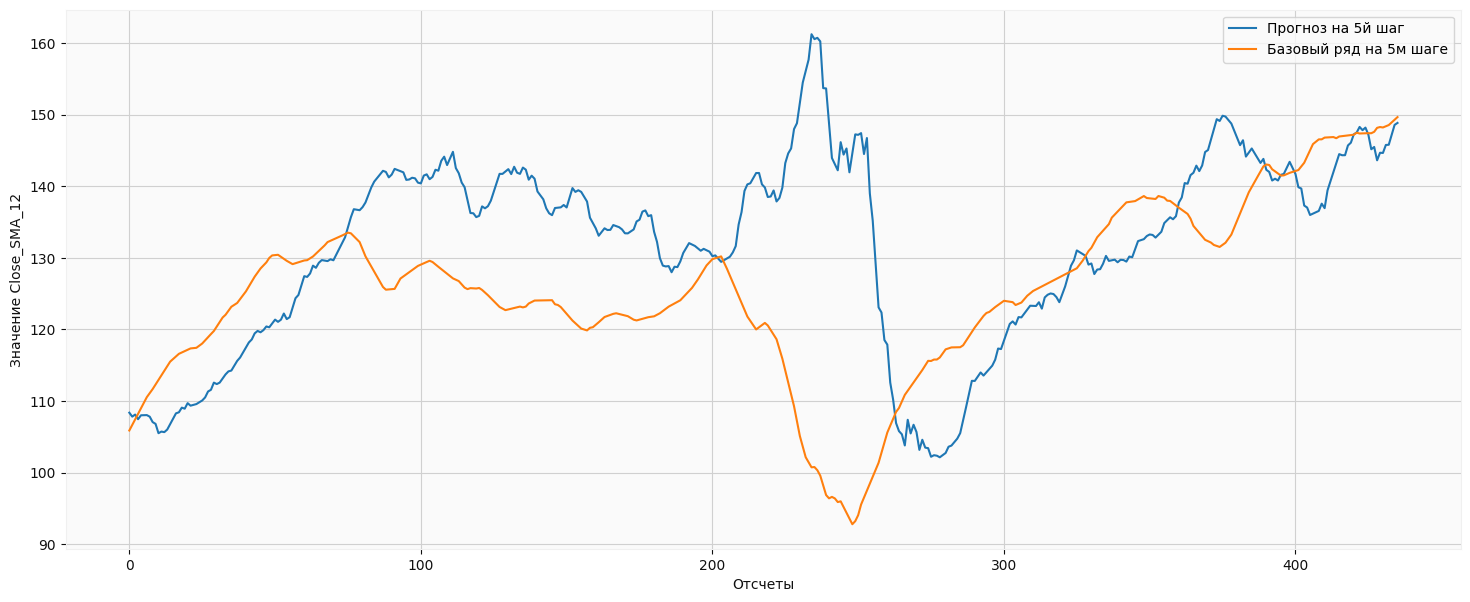

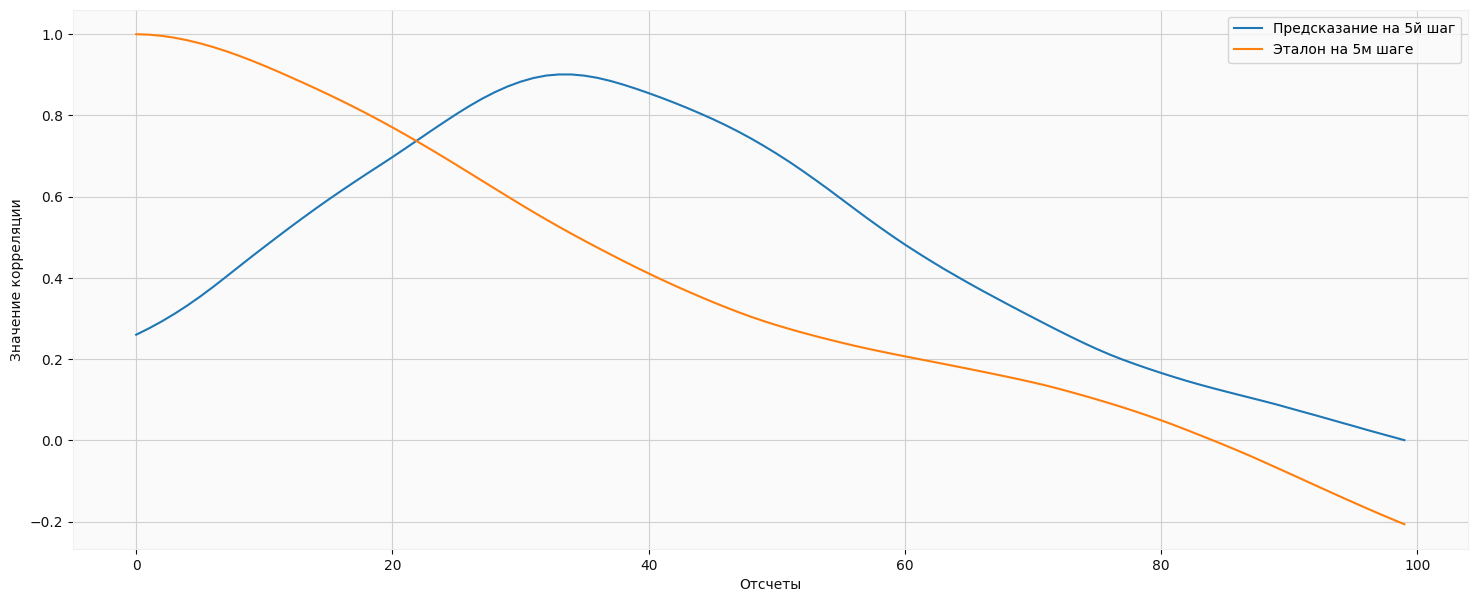

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(base_model, XVAL, YVAL, Y_SCAILER)
 
# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [4],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],             # по предсказанию на какие шаги отрисовываем корреляцию
          100,              # на сколько шагов смотрим корреляцию
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

# Классы для генерации случайной нейронной сети

In [ ]:
import random as random # Импортируем модель randim
import inspect # для получения имен аргументов функции

## Класс для определения слоев

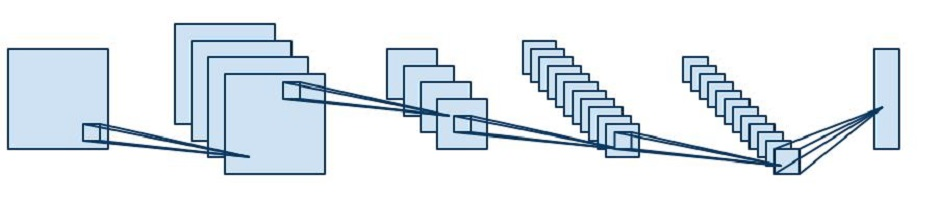

In [ ]:
class Set_net():
    '''
    Класс для формирования списка списков блоков,
    имен слоев и значений парамметров слоев
    type_net       - тип сети:
                     0 - Dense
                     1 - Conv
                     2 - Recur
                     None - любая
    activ_lays     - список функций активаций 
    activ_out      - выходная функция активации
    neiro_out      -  количество нейронов/сверток выходного слоя 
    limit          -  ограничения роста сети 
                      по умолчание 10**3 
    '''
    def __init__(self,
                 type_net,      # тип сети
                 activ_lays,    # список функций активаций 
                 activ_out,     # выходная функция активации
                 neiro_out,     # количество нейронов/сверток выходного слоя 
                 limit = 10**3, # ограничения роста сети   
                 ) -> None:

        # списки имен используемых слоев
        self.main_lays =  ['Dense', 'Conv1D']
        self.recur_lays = ['Lstm', 'BiEmbLstm']
        self.add_lays =   ['SCnv1D', 'Conv1DT', 'Conv1D_dilation_block']
        self.optim_lays = ['Dropout','BatchN', 'LayNorm']
        self.pooling_lays = ['MaxP1D','AvgP1D', 'Ups1D']
        self.embed_lays =   ['Embed']
        self.activ_lays = activ_lays
        self.activ_out = activ_out
        self.neiro_out = neiro_out

        # все используемые именя слоев
        self.use_layers  = self.main_lays + self.recur_lays + self.optim_lays\
                           + self.pooling_lays + self.embed_lays\
                           + self.add_lays + ['activ',]

        # создаем self переменные
        self.type_net = type_net
        self.limit = limit
        self.layer = tf.keras.layers

        # создаем список функций слоев
        self.makers_layer = (self.make_dense,
                             self.make_conv1D,
                             self.make_lstm,
                             self.make_biemblstm,
                             self.make_dropout,
                             self.make_batchn,
                             self.make_laynorm,
                             self.make_maxp1D,
                             self.make_avg1D,
                             self.make_upsam1D,
                             self.make_embedding,
                             self.make_sepconv1D,
                             self.make_conv1DT,
                             self.make_convblock_dilation,
                             self.make_activ,
        )
        # создаем словарь соответсвия имен и функций слоев
        self.dict_layers = dict(zip(self.use_layers, self.makers_layer))
        pass
    
    # Функции создания слоев
    def make_dropout(self, x, rate):
        lay = self.layer.Dropout(rate)(x)
        return lay

    def make_batchn(self, x):
        lay = self.layer.BatchNormalization()(x)
        return lay   

    def make_laynorm(self, x):
        lay = self.layer.LayerNormalization()(x)
        return lay   

    def make_dense(self,x, neiron):
        lay = self.layer.Dense(neiron)(x)
        return lay

    def make_conv1D(self, x, filter, kernel):
        # корректируем размерность под conv1D
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1D(filters = filter, 
                                kernel_size = kernel,
                                padding = 'same')(x)
        return lay

    def make_sepconv1D(self, x, filter, kernel):
         # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.SeparableConvolution1D(filters = filter, 
                                                kernel_size = kernel,
                                                padding = 'same')(x) 
        return lay

    def make_conv1DT(self, x, filter,  kernel):
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1DTranspose(filters = filter,
                                         kernel_size = kernel,
                                         padding = 'same')(x)
        return lay


    def make_maxp1D(self, x, pool):
        lay = self.layer.MaxPooling1D(pool_size = pool)(x)
        return lay

    def make_avg1D(self, x, pool):
        lay = self.layer.AveragePooling1D(pool_size = pool)(x)
        return lay

    def make_upsam1D(self, x, upsize):
        lay = self.layer.UpSampling1D(size = upsize)(x) 
        return lay   


    def make_lstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.LSTM(units = lstmon,
                              return_sequences = True,
                              )(x)
        return lay

    def make_embedding(self, x, in_emb, out_emb):
        # корректируем размерность под LSTM
        if len(x.shape) > 2: 
          x = self.layer.Flatten()(x)
        lay = self.layer.Embedding(input_dim = in_emb, 
                                             output_dim = out_emb)(x)                            
        return lay

    def make_biemblstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) > 2: 
           x = self.layer.Flatten()(x)
        # парамметры для Embedding слоя
        emb_in = x.shape[1]
        emb_out = min(64, emb_in//3)
        lay = self.layer.Embedding(input_dim = emb_in, 
                                              output_dim = emb_out)(x)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=True))(lay)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=False))(lay)
        return lay
      
    def make_convblock_dilation(self, x, filter,  kernel):
        def convs(x, n, f, rate, ln = False):
            x = self.layer.Conv1D(n, f, padding = "causal",
                            dilation_rate = rate,
                            activation="sigmoid")(x)
            x = self.layer.LayerNormalization()(x) if ln else x
            return x  
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            x = self.layer.Reshape((-1,1))(x)
        a = convs(x = x, n = filter,  f = filter, rate = 2, ln = True)
        b = convs(x = x, n = filter,  f = filter, rate = 4, ln = True)
        c = convs(x = x, n = filter,  f = filter, rate = 8, ln = True)
        d = convs(x = x, n = filter,  f = filter, rate = 16, ln = True)
        lay = self.layer.concatenate([x, a, b, c, d], axis = -1)
        return lay

    def make_activ(self, x, activ):
        lay = self.layer.Activation(activ)(x)
        return lay   
 

    # Метод построение случайного бота блока на основе bot_list блока 
    def __buildbot__(self, bot_list):
        '''
        Метод создает случайным образом в заданном диапазоне
        значения пришедщим парраметрам слоев в списке bot_list
        собирает их в список и выдает этот список
        '''
        bot = []
        for el in bot_list:
            if el == 'neiron':
                bot.append(2**random.randint(2,7))
            if el == 'activ':
                bot.append(random.randint(0, len(self.activ_lays)-1))
            if el == 'filter':
                bot.append(2**random.randint(2,7))
            if el == 'kernel':
                bot.append(random.randint(2,5))
            if el == 'pads':
                bot.append(random.choice(('valid','same')))
            if el == 'stride':
                bot.append(random.randint(1,2))
            if el == 'pool':
                bot.append(random.randint(2,4))
            if el == 'upsize':
                bot.append(random.randint(2,4))
            if el == 'rate':
                bot.append(round(random.random()*0.5,2)) 
            if el == 'lstmon':
                bot.append(random.randint(2,30))
            if el == 'in_emb':
                bot.append(random.randint(10,200))
            if el == 'out_emb':
                bot.append(max(20, bot[-1]//3))
        return bot

## Класс генерация блоков

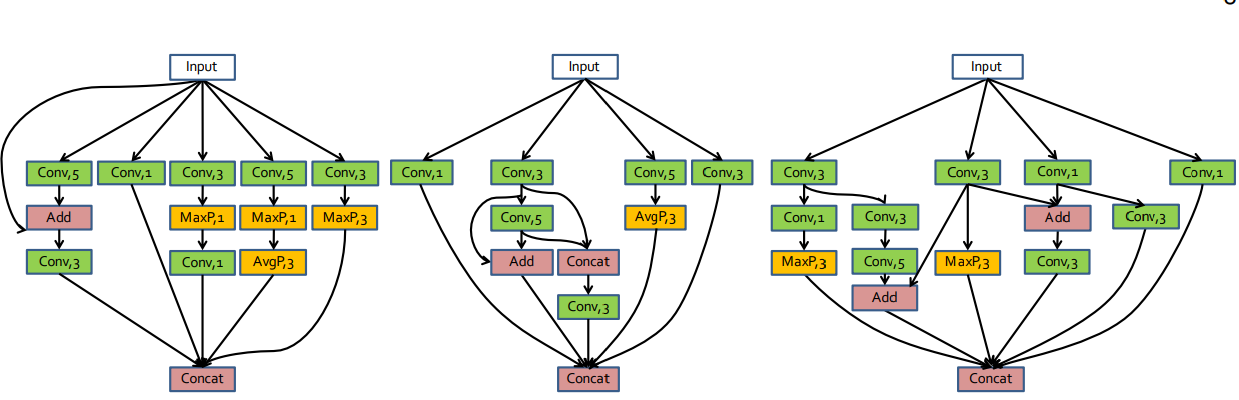

In [ ]:
class Make_blocks():
    '''
    Класс отвечающий за генерацию 
    блоков сети на основе данных из 
    ранее инициализированного класса set_net

    set_net - класс парамметров сети
    '''
   
    def __init__(self,
                set_net: object,                 
                ):
        # переназначенм переменные из класса set_net
        self.set_net = set_net  
        self.neiro_out = set_net.neiro_out   
        self.main_lays = set_net.main_lays
        self.add_lays = set_net.add_lays
        self.recur_lays = set_net.recur_lays 
        self.activ_out = set_net.activ_out
        self.limit = set_net.limit
        pass

    # ФУНКЦИИ КОРРЕКЦИИ СПИСКОВ БЛОКОВ
    def __correct__(self, block_list: list, name: str,
                   level = 0, insert = False):
        '''
        Метод коррекции пришедщего списка списка
        block_list - пришедщий список
        level - порог выше котого коррекция
        name - имя добавляемого слоя
        insert - если True то вставит до последнего,
              иначе вставит за последним
        '''
        # подбрасываем монетку
        bias = random.random()
        if bias >= level: # если выше порога, то корректируем для вывода
            if insert: # вставляем 
               block_list.insert(-1, name)
            else: # добавляем 
               block_list.append(name)
        return block_list

    # ФУНКЦИИ ГЕНЕРАЦИИ СПИСКОВ БЛОКОВ
    def __generateblock__(self,
                        max_lays: int,        # мак.количество слоев в блоке
                        prob_mp = 0.47,       # появление пуллинг слоя
                        prob_el = 0.65,       # Embedding до LSTM
                        prob_ac = 0.33        # появление слоя активации
                        ):
        '''
        Внутренний метод для геннерации списка
        из имен слоев
        max_lays - мак. возможное количество слоев в блоке
        '''       
        # определяем количество слоев в блоке не более max_lays  
        layers = random.randint(0, max_lays) 

        # определяем слои сетина основы заданного типа сети
        #############################################
        # если тип не задан
        if self.set_net.type_net == None:
            self.net_lays = self.main_lays + self.add_lays + self.recur_lays 
        # если рекурентный тип сети
        elif self.set_net.type_net == 2:
            self.net_lays = self.recur_lays
        # если 0 - Dense или 1 - Conv тип сети
        else:
            # выбираем из main_lays индексом, который равен типу сети
            self.net_lays = [self.main_lays[self.set_net.type_net]]
        #############################################
        # отобранные по типу слою и плюс слои оптимизации 
        used_lays = self.net_lays + self.set_net.optim_lays
        #base_lays + = self.set_net.recur_lays

        block_list = [] # список для сбора имен слоев
        # итерируемся по слоям
        for i in range(layers):
            if not i: # если 0_й слой
              # вставляем случайное имя из слоев сети
              block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
            else:          
              # если пришло имя из слоя оптимизации
              if block_list[-1] in self.set_net.optim_lays:
                # вставляем случайное имя из слоев сети
                block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
              else: # иначе выбираем из слоев сети и оптимизации
                block_list = self.__correct__(block_list,
                                              random.choice(used_lays))           
              # случайное появление пулинга после cвертки
              if block_list[-1]=="Conv1D" and i < layers:
                # случайно по prob_mp добавляем пуллинг слой
                block_list = self.__correct__(block_list,
                                            random.choice(self.set_net.pooling_lays),
                                            level = prob_mp)
              # случайное появление Embeding переd LSTM
              if block_list[-1]=="Lstm" and i < layers:
                # случайно по prob_el вставляем Embeding слой переd LSTM
                block_list = self.__correct__(block_list,
                                            self.set_net.embed_lays[0],
                                            level = prob_el,
                                            insert = True)
              # случайное появление активации
              if block_list[-1] != 'activ' and i < layers:
                # случайно по prob_ac добавляем 'activ'
                block_list = self.__correct__(block_list, 'activ',
                                            level = prob_ac)
              # если набрали длину 
              if len(block_list) == layers:
                  break
        # если    
        #if not list(set(block_list) & set(self.net_lays)):
            #return []

        return block_list


    def sostav_blockov(self, q_lst: list): 
        '''
        Метод генерирует список из списков блоков
        размера полученнного из q_lst
        q_lst - список длины количества блоков,
                где значения списка определяет 
                количество слоев в блоке
        '''
        blockov_list = []
        for i in range(len(q_lst)):
            block = self.__generateblock__(max_lays = q_lst[i])
            blockov_list.append(block) 
        return  blockov_list  


    def buildblock_bot(self, block_lst: list):
        '''
        Метод собирает список списков парамметров
        слоев каждого блока будущей сети
        block_lst - список списков слоев будущей сети
        '''
        botov_lst = []
        for i in range(len(block_lst)):
            # получаем список имен парамметров слоев блока
            bot_lst = self.__bot_block__(block_lst[i]) 
            # получаем список самих парамметров слоев блока из имен парамметров
            bot = self.set_net.__buildbot__(bot_lst)
            botov_lst.append(bot) 
        return   botov_lst 

    ######################################################################

    # ФУНКЦИИ БОТОВ
    # определение состава бота для блока из созданого случайно block_list
    def __bot_block__(self, block_list: list):
        '''
        Метод формирует список списков парамметров слоев в блоках
        на основе списка имен слоев блока из block_list
        block_list - список имен слоев блока
        '''
        bot_list = []
        for lay in block_list:
          if lay == 'activ':
              # если имя слоя 'activ', то просто добавляем 'activ'
              bot_list.append('activ') 
          else: # иначе
              # созданный в set_net словарь соответсвия
              # имен слоев и функций их формирующих
              maker_lay = self.set_net.dict_layers[lay]
              # методом param_layer определяем парамметры 
              # у функций формирующих слои
              param = self.__param_layer__(maker_lay)
              # добавляем эти парамметры в bot_list
              if len(param): bot_list += param 
              else: pass
        return bot_list


    # Построение случайного бота попупуляции 
    def buildpopulbot(self, q_tyblocks: int, q_lays: int):
        '''
        Метод случйно генерирует список, который будет
        ботом_попупаляции сетей
        q_tyblocks - максимально возможное количество блоков в сети
        q_lays - максимально возможное количество слоев в блоках в сети
        '''
        # генерируем количество блоков
        qblocks = random.randint(1, q_tyblocks)  
        # генерируем количество слоев в блоке 
        genlays = random.randint(1, q_lays)  
        
        # собираем бота популяции
        populbot = []
        # добавляем ген макс. возможное количество блоков сети популяции
        populbot.append(qblocks)   
        # добавляем ген макс. возможное количество слоев в блоках сети популяции
        populbot.append(genlays) 
        # ген для случайного выбора между Dense, Conv, LSTM в пред_выходном слое
        populbot.append(random.random()) 
        # ген делать или нет пред_выходном слой
        populbot.append(random.randint(0,1)) 
        # ген ко-ва нейронов/фильтров пред_выходном слое
        populbot.append(2**random.randint(2,7)) 
        # ген окон если свертки в пред_выходном слое
        populbot.append(random.randint(2,5)) 
        # ген делать/нет слой нормализации перед посл-й активацией    
        populbot.append(random.randint(0,1)) 
        # ген какую делаем активацию в пред_выходном слое из списка активаций
        populbot.append(random.randint(0, len(self.set_net.activ_out)-1)) 
        # ген под сложность сети, будет назначается методом сборки сети
        populbot.append(0) 
        # ген под ярусность сети, будет назначается методом сборки сети
        populbot.append(0)                   
        return populbot

        
    # ФУНКЦИИ ФОРМИРОВАНИЯ БЛОКОВ
    # без степеней - прямые значения нейронов
    def __buildblock__(self, tensor: object,
                       block_list: list, bot: list):
        '''
        Метод строет блок слоев на основе списка 
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''
        
        # будет добавляться больше или меньше 0 значение 
        # если к-во параметров > или < 1
        b=0 
        # иттерируеимя по слоям блока
        for i, lay in enumerate(block_list):
          # созданный в set_net словарь соответсвия
          # имен слоев и функций их формирующих
          maker_lay = self.set_net.dict_layers[lay]
          # получаем колчество парамметров функции слоя
          k = len(self.__param_layer__(maker_lay))
          # формируем список аргументов для функции слоя
          if k: # если есть доп.параметры в слое
            # получаем доп.параметры в слоя
            parametrs = [bot[i+b+j] for j in range(k)]
            # собираем аргументы для активации
            if lay=='activ':
              args = [tensor]+[self.set_net.activ_lays[parametrs[0]]]
            # собираем аргументы для других многопарамметных слоев
            else: args = [tensor]+parametrs
          # собираем аргументы если слой без параммeтров
          else: args=[tensor]
          # формируем слой на основе нужных и собранных args
          tensor = maker_lay(*args)
          # обнавляем b
          b+=k-1
        return tensor # выводим выходной тензор блока


    def __buildblockout__(self,
                      indata: object,    # входные данные
                      bot_pop: list,     # бот популяции (может)
                       ):
        '''
        Метод строет блок слоев на основе списка 
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''
        x = indata
        if self.set_net.type_net == 0:
            # Добавление предпоследнего полносвязного слоя
            if bot_pop[3]!=0:
                x = self.set_net.make_dense(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        elif self.set_net.type_net == 1:
            # Добавление предпоследнего conv1D слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под conv1D
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_conv1D(x, bot_pop[4], bot_pop[5])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        elif self.set_net.type_net == 2:
            # Добавление предпоследнего LSTM слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под lstm
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_lstm(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        else: # случайный выбор типа выходного блока от бота        
          if bot_pop[2] < 0.3:
              # Добавление предпоследнего CONV слоя
              if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под conv1D
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_conv1D(x, bot_pop[4], bot_pop[5])
              # Добавление нормализации перед последним полносвязным слоем
              if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

          if bot_pop[2] < 0.7:
              # Добавление предпоследнего полносвязного слоя
              if bot_pop[3]!=0:
                  x = self.set_net.make_dense(x, bot_pop[4])
              # Добавление нормализации перед последним полносвязным слоем
              if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

          else:
              # Добавление предпоследнего lstm слоя
              if bot_pop[3]!=0:
                  # высчитываеи корректировку размерности тензора под lstm
                  newshape = self.__redim__(x.shape[1], 2, sort = 0)
                  x = tf.keras.layers.Reshape(newshape)(x)
                  x = self.set_net.make_lstm(x, bot_pop[4])
              # Добавление нормализации перед последним полносвязным слоем
              if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 
        return x

    ###########################################################
    ######         вспомогательные методы класса         ######
    ###########################################################
    def __param_layer__(self, method: object):
        '''
        Метод выводит количеству управляющих
        парамметров пришедшей функции method
        на онове inspect.getfullargspec
        method - функция у которой определяютя 
                 количество управляющих парамметров
        '''
        return inspect.getfullargspec(method).args[2:]


    # простое соединение произвольного к-ва блоков
    def __flatconcat__(self, set_blocks: list):
        '''
        Метод конкантенации списка тензоров блоков
        через промежуточный перевод в вектор Flatten
        с контролем пространства паремметров и при
        превышении к-ва размерностей или размера 
        паремметров, применение GlobalAveragePooling1D
        взамен Flatten
        '''
        out = []
        # иттерируемся по списку тензоров
        for i in range(len(set_blocks)):
            # не является ли уже вектором
            if set_blocks[i].shape != (None, 1): 
                # Берем shape тензора         
                control_shape = set_blocks[i].get_shape()
                # Если много размерностей или много парамметров у тензора
                if np.prod(control_shape[1:]) > self.limit \
                 and len(control_shape) > 3:
                    # Добавляем слой GlobalAveragePooling1D
                    lay = tf.keras.layers.GlobalAveragePooling1D()(set_blocks[i])
                    out.append(lay)               
                else: # Добавляем слой Flatten
                    lay = tf.keras.layers.Flatten()(set_blocks[i])
                    out.append(lay)
            else: # Иначе выходим
                break
        # Конкантенируем тензоры по axis = -1 и выводим
        out = tf.keras.layers.concatenate(out, axis = -1)
        return  out        


    def __redim__(self, size, dim, sort = None):
        '''
        Метод метод считает выходной список размерностей
        длины dim из прешедшего размера парамметров size,
        на основе разложения на простые множители
        input:
        size - входящий размер размерности слоя
        dim  - длина всписка выходной размерности
        sort - сортировать ли список простых множителей
                как - 0 - возраст-й, 1 - убывающий
        output:
        outshape - выходной список размерностей
                   длины dim
        '''
        # собираем в res простые множители чиcла n
        res, n, d = [], size, 2
        while d * d <= n:
            if n % d == 0:
                res.append(d)
                n //= d
            else:
                d += 1
        if n > 1:
            res.append(n) 
        ##########################################
        
        # сортируем или перемешиваем список простых множителей
        if sort == 0 or sort == 1:
            res = sorted(res, reverse=sort)
        else:      
            res = np.random.permutation(res)
        ##########################################

        # формируем список размерностей длины dim   
        s = len(res)//dim  # целое число отношения len(res) и dim
        if s >= 1 and dim == 2:
            # получим outshape размерности 2 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:])]

        elif s >= 1 and dim == 3:
            # получим outshape размерности 3 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:2*s]),
                         np.prod(res[2*s:])]

        elif s < 1 and dim == 3:
            s = len(res)//(dim-1)
            # получим outshape размерности 2 из произведений частей и 
            # добавляем ось справа
            outshape = [int(np.prod(res[:s])), int(np.prod(res[s:])), 1]

        elif (s < 1 and dim == 2) or dim == 1:
            # просто добавляем ось справа
            outshape = [size, 1]       
      
        return outshape

Пример как работает redim

In [ ]:
# как работает redim
a = np.arange(10)[1:]#[::-1]
d = 2
k = len(a)//d
print(k)
[np.prod(a[:k]), np.prod(a[k:])]

4


[24, 15120]

In [ ]:
# параметры для создания сети
q_tyblocks = 10  # возможное количество блоков
q_lays = 5       # возможное количество слоев
type_net = None  # тип сети
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
activ_out = ['linear'] #'softmax','sigmoid']
neiro_out = y_train.shape[1]      # нужное количество входных нейроной
# инициализируем Set_net на основе заданных парамметров
choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)

# инициализируем класс структуры блоков на основе парраметров сети
blocks = Make_blocks(choosing_net)

# генерируем бот_популяции сетей
bot_pop = blocks.buildpopulbot(q_tyblocks, q_lays)
print(f'Бот структуры популяции сетей - {bot_pop}') 

# генерируем максимально возможное количество слоев в блоках сети
gen_lst  = [random.randint(0, bot_pop[1]) for i in range(bot_pop[0])]
print(f'Макс. кол-во слоев в каждом блоке - {gen_lst}') 

setblockov = blocks.sostav_blockov(gen_lst)
bot = blocks.buildblock_bot(setblockov)


print(f'Список списков слоев сети - {setblockov}')    
print(f'Бот парамметров слоев сети - {bot}')                    

Бот структуры популяции сетей - [9, 1, 0.618311582862053, 1, 8, 4, 0, 0, 0, 0]
Макс. кол-во слоев в каждом блоке - [0, 1, 0, 0, 1, 1, 1, 1, 0]
Список списков слоев сети - [[], ['Conv1DT'], [], [], [], ['Conv1DT'], ['BiEmbLstm'], ['Dense'], []]
Бот парамметров слоев сети - [[], [64, 4], [], [], [], [8, 7], [12], [128], []]


## Класс сборки нейронки

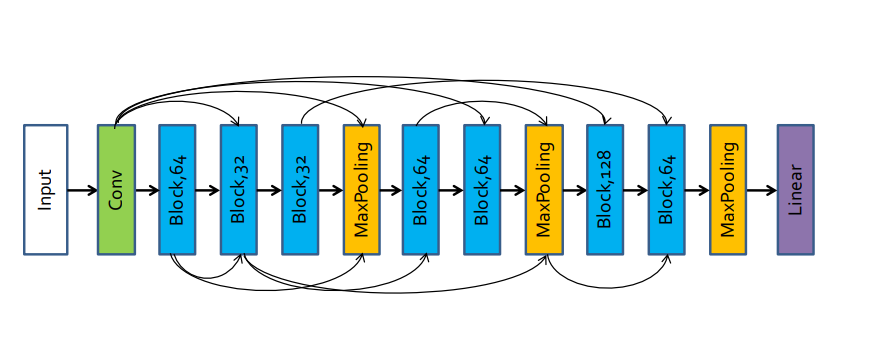

In [ ]:
class WildregressModel():
      '''
      Класс который формирует и выдает сеть

      input_shape - размерность входящих в сеть данных
      control_level_shape - размер допустимого размера парамметров 
                            слоев когда требуется применение 
                            GlobalAveragePooling1D для понижения
                            размерности, по умолчанию 10**3
      q_level - количество блоков с которого можно строить 
                многоярусную сет, по умолчанию 3
      '''
      
      def __init__(self,
                  input_shape: list,
                  control_level_shape = 10**3,
                  q_level = 3
                  ):
        
          self.input_shape = input_shape
          self.control = control_level_shape
          self.q_level = q_level
          pass

      def __call__(self,
                  bot_pop: list,
                  bot: list,
                  setblockov: list,
                  blocks: object
                  ):
          '''
          Класс который формирует и выдает сеть на основе
          bot_pop - бот_популяции сетей
          bot - спискок парамметров слоев блоков
          setblockov - списка списков слоев имен блока
          blocks - класс построения блоков
          '''
          # Входной слой
          inputs =  tf.keras.layers.Input(self.input_shape)  
          # размерность даннх сети без 0го, которы None
          dim_net = len(self.input_shape) - 1
          # type_net = int(bot_pop[2])

          ##### отбор блоков с основными слоями для входа нейронки ############
          idx=[] # хранения индексов блоков с основными слями сети 
          # отбираем индексы блоков с основными слями сети
          for block in setblockov:
              if [x for x in blocks.net_lays if x in block]:
                idx.append(setblockov.index(block)) 
          # берем первый по счету, и если был посев, для входа уходит сразу
          in_nb = idx[0] 
          # получаем тензор от первого блока
          in_block = blocks.__buildblock__(inputs, setblockov[in_nb],
                                           bot[in_nb])

          #####################################################################
          ############# отбор для скрытых блоков ##############################
          # ищем и оставляем только один пустой блок 
          new_setblockov = []
          new_bot = []
          emp = 0 # счетчик пустых блоков

          # Если был посев, то первый блок для входа уходит сразу -
          for i in range(1,len(setblockov)): # не попадет во внутр.блоки
              #print('metka 4')                                    
              if emp == 0 and setblockov[i] == []:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])
                  emp+= 1 
              elif emp != 0 and setblockov[i] == []:
                  pass    
          # оставляем только один пустой блок
          # на его основе создается проброс от входной части до concat
              else:    
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])  

          #####################################################################
          #  print('Сборка многоярусной модели')
          #####################################################################
          if len(new_setblockov) > self.q_level:
              ############### БЛОК соединения скрытых блоков  #################
              ########## создание гена для ярусности и  сложности сети ########
              if not bot_pop[9]:
                  # определяем ярусность сети
                  bot_pop[8] = random.choice(np.arange(2,
                                                       len(new_setblockov)-1))
                   # отбор блоков в ярусы
                  bot_pop[9] = [0] + [len(new_setblockov)] \
                                   + sorted(np.random.choice(np.arange(1,
                                            len(new_setblockov)-1),              
                                            bot_pop[8], replace=False))                                                                                      
                  tiers = bot_pop[9]  # состав ярусов
              else:
                  tiers = bot_pop[9]  # состав ярусов
            ###################################################################
              brickblock = [] # ссписок для сборв внутренних блоков
              # итеррируемся по ярусам
              for j in range(len(tiers)-1):
                  indata = in_block if not j else concdata
                  hidblock = []
                  # отбираем в conc только возможные блоки
                  for i in range(tiers[j], tiers[j+1]):
                      ##########################################################
                      # создаем внутренний блок
                      hid = blocks.__buildblock__(indata,
                                              new_setblockov[i],
                                              new_bot[i])
                      # собираем список внутренних блоков для конкатенации
                      hidblock.append(hid)
                  # еслм набрали в список внутренних блоков
                  if len(hidblock):
                    # конкатенируем через выпрямления в вектора
                    concdata = blocks.__flatconcat__(hidblock)
                    # ищем замену размерности
                    newshape = blocks.__redim__(concdata.shape[-1],
                                                dim_net+1, 
                                                sort = 0)
                    # трансформируем размерность тензора
                    concdata = tf.keras.layers.Reshape(newshape)(concdata)
                    brickblock.append(concdata)
              # соединяем блоки
              to_out = blocks.__flatconcat__(brickblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если есть блоки для одноэтажной модели
          elif len(new_setblockov):
          #####################################################################
          #    print('Сборка одноэтажной модели')
          #####################################################################
              hidblock = [] 
              for i in range(len(new_setblockov)):
                  hid =  blocks.__buildblock__(in_block, new_setblockov[i],
                                           new_bot[i])
                  #hid =  tf.keras.layers.Reshape((-1,1))(hid)
                  hidblock.append(hid)
              ################################################################
              # соединяем блоки
              to_out = blocks.__flatconcat__(hidblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если нет блоков, то берем тензор с входного блока
          else:
              # переводим в вектор входной тензор
              in_block_out = blocks.__flatconcat__([in_block])
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(in_block_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Финальный слой под вашу задачу
          out = tf.keras.layers.Dense(units = blocks.neiro_out,
                                      activation = blocks.activ_out[bot_pop[7]]
                                      )(out_block)
          # формируем граф модели                           
          model = tf.keras.Model(inputs, out)
          return model



In [ ]:
# параметры для создания сети
q_tyblocks = 9  # возможное количество блоков
q_lays = 5       # возможное количество слоев
type_net = None  # тип сети
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
activ_out = ['linear'] #'softmax','sigmoid']
neiro_out = y_train.shape[1]      # нужное количество входных нейроной
# инициализируем Set_net на основе заданных парамметров
choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)

# инициализируем класс структуры блоков на основе парраметров сети
blocks = Make_blocks(choosing_net)

# генерируем бот_популяции сетей
bot_pop = blocks.buildpopulbot(q_tyblocks, q_lays)
print(f'Бот структуры популяции сетей - {bot_pop}') 

# генерируем максимально возможное количество слоев в блоках сети
gen_lst  = [random.randint(0, bot_pop[1]) for i in range(bot_pop[0])]
print(f'Макс. кол-во слоев в каждом блоке - {gen_lst}') 

setblockov = blocks.sostav_blockov(gen_lst)
bot = blocks.buildblock_bot(setblockov)


print(f'Список списков имен слоев сети - {setblockov}')    
print(f'Бот парамметров слоев сети - {bot}')                    

Бот структуры популяции сетей - [3, 5, 0.9979941222551485, 1, 128, 5, 1, 0, 0, 0]
Макс. кол-во слоев в каждом блоке - [3, 4, 4]
Список списков имен слоев сети - [['Lstm'], ['SCnv1D'], ['Dense', 'LayNorm', 'activ']]
Бот парамметров слоев сети - [[17], [64, 5], [8, 3]]


In [ ]:
# инициализируем класс формирования сети
make_model = WildregressModel(INSHAPE)
# формируем модель из ботов
some_model = make_model(bot_pop,        # бот_популяции сетей 
                        bot,            # бот парамметров слоев сети
                        setblockov,     # список списков имен слоев сети
                        blocks          # класс построения блоков
                        )

print()
print(bot_pop)


[3, 5, 0.9979941222551485, 1, 128, 5, 1, 0, 0, 0]


In [ ]:
# Отображение сводки модели
some_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 29, 54)]     0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 29, 17)       4896        ['input_14[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 29, 8)        144         ['lstm_24[0][0]']                
                                                                                                  
 layer_normalization_30 (LayerN  (None, 29, 8)       16          ['dense_27[0][0]']               
 ormalization)                                                                             

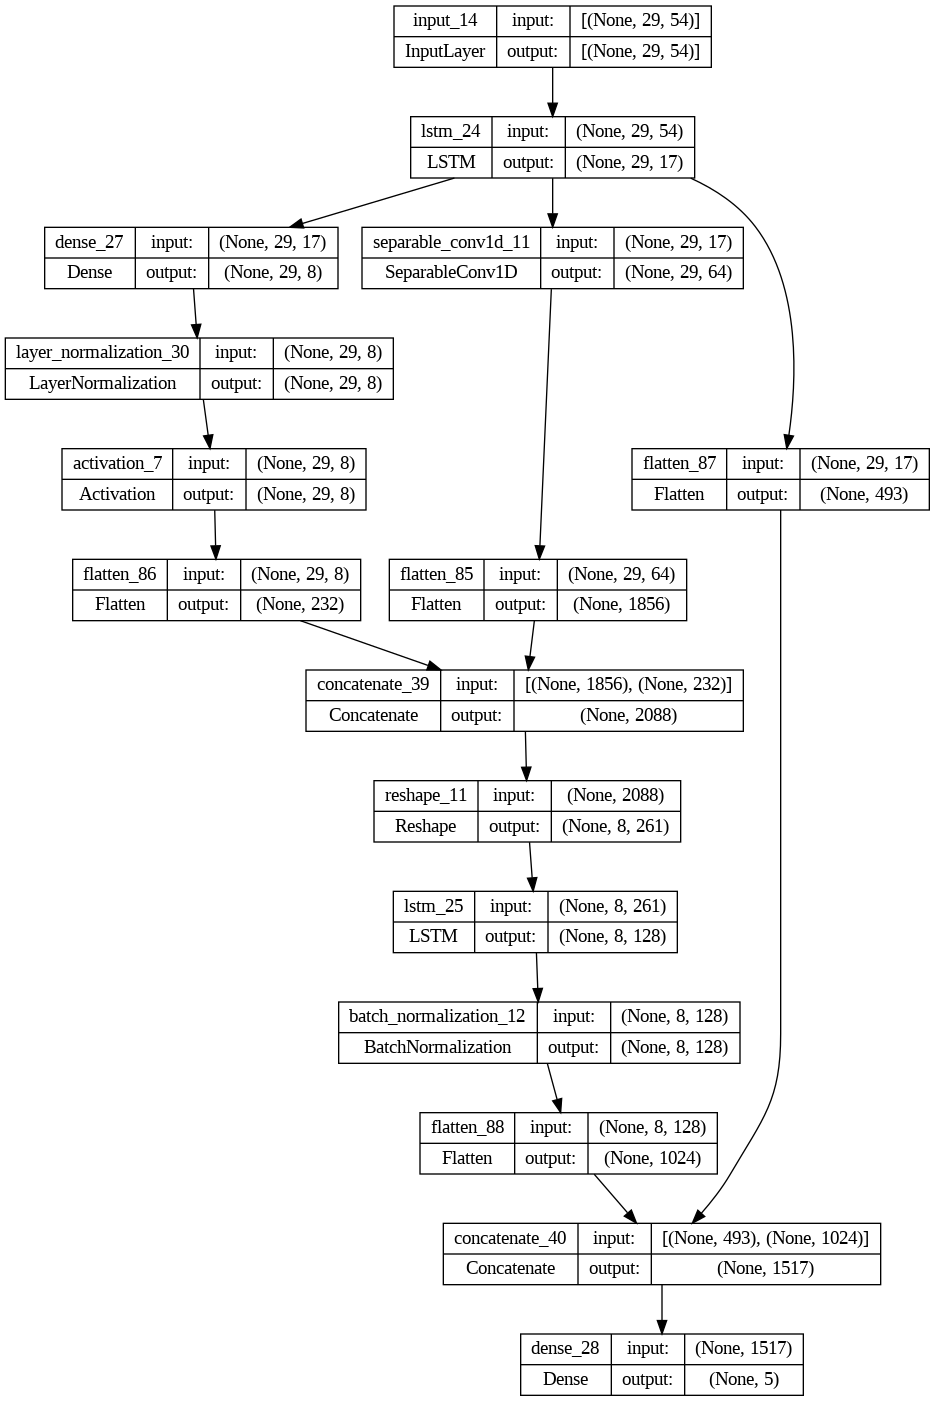

In [ ]:
tf.keras.utils.plot_model(some_model, show_shapes=True)

# Тест сборки нейронки

## Как будем оценивать точность модели и проблему автокорреляции

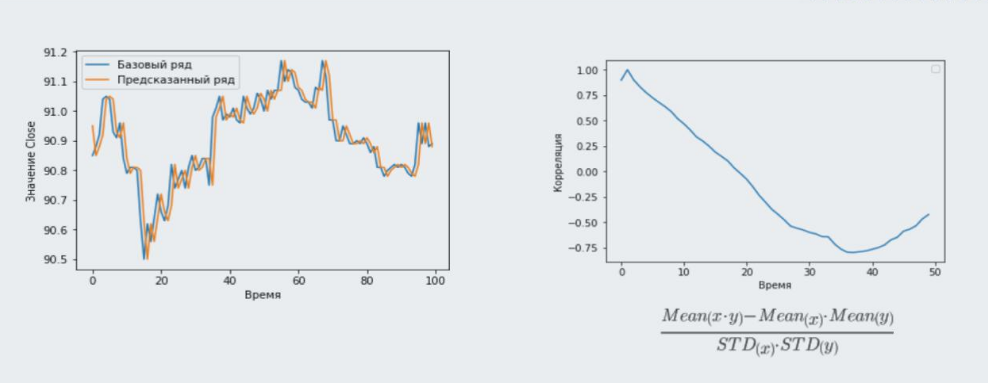

### Декоратор для остановки цикла

Данный декоратор поможет нам контролировать слишком длительные процесс, например:
- долгое создание модели из-за ее чрезмерной сложности
- долгое оценочное обучение модели из-за ее чрезмерной сложности

гитхаб - https://github.com/glenfant/stopit

статья - https://theautomatic.net/2021/11/27/how-to-stop-long-running-code-in-python/

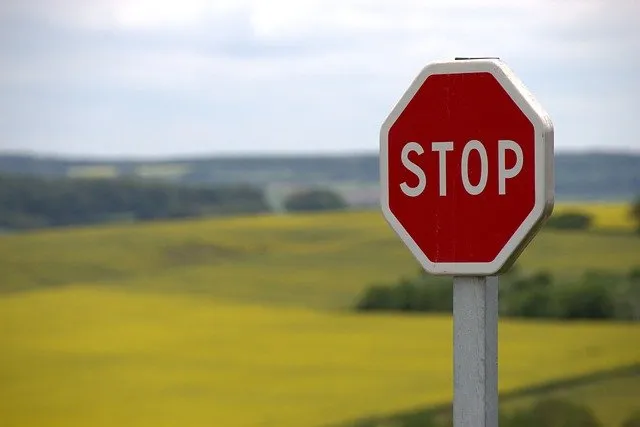


In [ ]:
!pip install stopit -q # установка библиотека контроля времени
from stopit import threading_timeoutable as timeoutable

Пример работы декоратора

In [ ]:
from tqdm import tqdm
 
@timeoutable(default='not finished')
def count(upper):
    for i in tqdm(range(upper)):
        i = i * 2   
    return i

In [ ]:
result = count(timeout = 5, upper = 10**8)
clear_output()
result

'not finished'

### Функция на оценки

In [ ]:
import time # библиотека времени

# Колбек для подсчета в функции ниже средней скорости на эпохе
class TimeHistory(tf.keras.callbacks.Callback):
    # создаем пустой список вначале обучения
    def on_train_begin(self, logs={}):
        self.times = []
    # запоминаем время вначале эпохи
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    # запоминаем время обучения на эпохе
    def on_epoch_end(self, batch, logs={}):
        # добавляем в список в конце эпохи
        self.times.append(time.time() - self.epoch_time_start)


# Функция на оценки с добавленным колбеком времени
@timeoutable(default='превышение лимита времени') # Декоратор для контроля времени
def evaluate_model(model, y_scaler, train_gen,
                   val_gen, ep, verb, optimizer,
                   loss, channels, predict_lag):
      '''
      Функция оценки модели на точность и автокорреляцию, с обучение
      и проверкой эффекта автокорреляции
      model       - тестируемая модель
      y_scaler    - ранее обученный скэйлер для ответов
      train_gen   - генератор данных для обучения модели
      val_gen     - генератор данных для проверки модели
      ep          - количество эпох оценосного обучения
      verb        - показывать ли процесс обучения
      optimizer   - используемый оптимайзер для обучения
      loss        - используемая функция потерь для обучения
      channels    - каналы в ответе модели для проверки автокорреляции
      predict_lag - на сколько шагом предсказание
      '''
      # сбрасываем оценку на случай пересечения названия с global переменной
      val = 0
      # Компилируем модель
      model.compile(optimizer, loss)
      # инициализируем колбек в дальнейшем для поиска более быстрых и оптимизации поиска
      time_callback = TimeHistory()
      # обучаем модель
      history = model.fit(train_gen,
                          epochs=ep, 
                          verbose=verb,
                          validation_data=val_gen,
                          callbacks=[time_callback])
      # получаем данные по времени каждой эпохи
      times_back = time_callback.times
      # берем среднее время эпохи
      time_ep = np.mean(times_back) 

      # Прогнозируем данные текущей сетью
      (pred_val, y_val_true) = get_scalepred(model, XVAL, YVAL, y_scaler)
      # Возвращаем автокорреляцию
      corr, own_corr = auto_corr(pred_lags = channels,
                                 corr_steps = predict_lag,
                                 y_pred = pred_val,
                                 y_true = y_val_true,
                                 show_graf = False,
                                 return_data = True)
      # Считаем MAE автокорреляции и умножаем (прибавляем) ошибку обучения
      val = 100*tf.keras.losses.MAE(corr, own_corr).numpy()*history.history["val_loss"][-1] 
      # Возвращаем точность и среднее время эпохи
      return val, time_ep  

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# функция потерь
loss = tf.keras.losses.MSE

# получаем оценку по времени и смешанной точности нашей модели
result = evaluate_model(
                # парамметр от декаратора
                timeout = 50,                # время в сек отводимое на оценку
                # собственные парамметры функции
                model = some_model,          # тестируемая модель
                y_scaler = Y_SCAILER,        # обученный скейлер для y
                train_gen = train_datagen,   # генератор данных для обучения
                val_gen = val_datagen,       # генератор данных для проверки
                ep = 3,                      # эпох обучения
                verb = 1,                    # отображать ли обучение
                optimizer = optimizer,       # оптимизатор
                loss = loss,                 # функция потерь
                channels = np.arange(PREDICT_LAG),  # Отображение сводки модели
                predict_lag = PREDICT_LAG)   # На сколько шагов предсказание

# выводим результат оценки                
if len(result) > 2:
  clear_output()
  print(result)     
else:                   
  print(f'Оценка модели как по ошибке и автокорреляции {result[0]:0.7f}')
  print(f'Среднее время эпохи {result[1]:0.2f} секунд')

Epoch 1/3
112/112 [==============================] - 17s 71ms/step - loss: 0.1132 - val_loss: 0.4337
Epoch 2/3
112/112 [==============================] - 7s 66ms/step - loss: 0.0061 - val_loss: 0.3203
Epoch 3/3
14/14 [==============================] - 1s 19ms/step
Оценка модели как по ошибке и автокорреляции 17.5790188
Среднее время эпохи 9.82 секунд


## Сохраненный состав модели good_model

In [ ]:
# вариант из презентации
bot_pop = [7, 1, 0.9482575730793709, 1, 16, 7, 0, 0, 0, 0]
bot = [[], [], [32, 5], [256], [], [], []]
setblockov = [[], [], ['Conv1DT'], ['Dense'], [], [], []]
print(bot_pop)
print(bot)
print(setblockov)

In [ ]:
# иной вариант
bot_pop = [4, 1, 0.5118121503905241, 1, 256, 6, 0, 0, 0, 0]
bot = [[], [18], [8, 5], []]
setblockov = [[], ['Lstm'], ['Conv1D_dilation_block'], []]
print(bot_pop)
print(bot)
print(setblockov)


[4, 1, 0.5118121503905241, 1, 256, 6, 0, 0, 0, 0]
[[], [18], [8, 5], []]
[[], ['Lstm'], ['Conv1D_dilation_block'], []]


In [ ]:
# инициализируем класс формирования сети
make_model = WildregressModel(INSHAPE)
# формируем модель из ботов
good_model = make_model(bot_pop,        # бот_популяции сетей 
                        bot,            # бот парамметров слоев сети
                        setblockov,     # список списков имен слоев сети
                        blocks          # класс построения блоков
)
print()
print(bot_pop)


[4, 1, 0.5118121503905241, 1, 256, 6, 0, 0, 0, 0]


In [ ]:
# Отображение сводки модели
good_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29, 54)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 29, 18)       5256        ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 29, 8)        1160        ['lstm_2[0][0]']                 
                                                                                                  
 conv1d_7 (Conv1D)              (None, 29, 8)        1160        ['lstm_2[0][0]']                 
                                                                                            

In [ ]:
tf.keras.utils.plot_model(good_model, show_shapes=True)

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# функция потерь
loss = tf.keras.losses.MSE


result = evaluate_model(timeout = 55,                 # время в сек отводимое на оценку
                         model = good_model,          # тестируемая модель
                         y_scaler = Y_SCAILER,        # обученный скейлер для y
                         train_gen = train_datagen,   # генератор данных для обучения
                         val_gen = val_datagen,       # генератор данных для проверки
                         ep = 3,                      # эпох обучения
                         verb = 1,                    # отображать ли обучение
                         optimizer = optimizer,       # оптимизатор
                         loss = loss,                 # функция потерь
                         channels = np.arange(PREDICT_LAG),  # Отображение сводки модели
                         predict_lag = PREDICT_LAG)   # На сколько шагов предсказание
# выводим результат оценки                           
if len(result) > 2:
  clear_output()
  print(result)     
else:                   
  print(f'Оценка модели как по ошибке и автокорреляции {result[0]:0.7f}')
  print(f'Среднее время эпохи {result[1]:0.2f} секунд')

## Обучение сгенерированной модели

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.MSE #Huber() # 
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.7, 
                                                 patience = 3,
                                                 min_lr = 1e-9, verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [ ]:
from time import time
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 100,
                          batch_size = 32,
                          callbacks=[early_stopping, reduce_lr],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/100
112/112 [==============================] - 18s 73ms/step - loss: 0.5212 - val_loss: 0.0220 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 9s 76ms/step - loss: 0.0353 - val_loss: 0.1115 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 9s 80ms/step - loss: 0.0369 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 9s 79ms/step - loss: 0.0103 - val_loss: 0.0472 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 7s 59ms/step - loss: 0.0044 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/100
112/112 [==============================] - 5s 49ms/step - loss: 0.0044 - val_loss: 0.0076 - lr: 0.0010
Epoch 7/100
112/112 [==============================] - 7s 60ms/step - loss: 0.0035 - val_loss: 0.0078 - lr: 0.0010
Epoch 8/100
112/112 [==============================] - ETA: 0s - loss: 0.0022
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
112/112 [==============================]

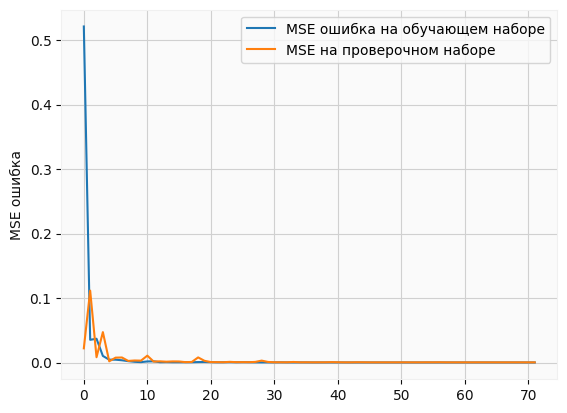

In [ ]:
plt.plot(history.history['loss'], 
         label='MSE ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='MSE на проверочном наборе')
plt.ylabel('MSE ошибка')
plt.legend()
plt.show()

## Оценка модели на VAL данных

14/14 [==============================] - 2s 21ms/step


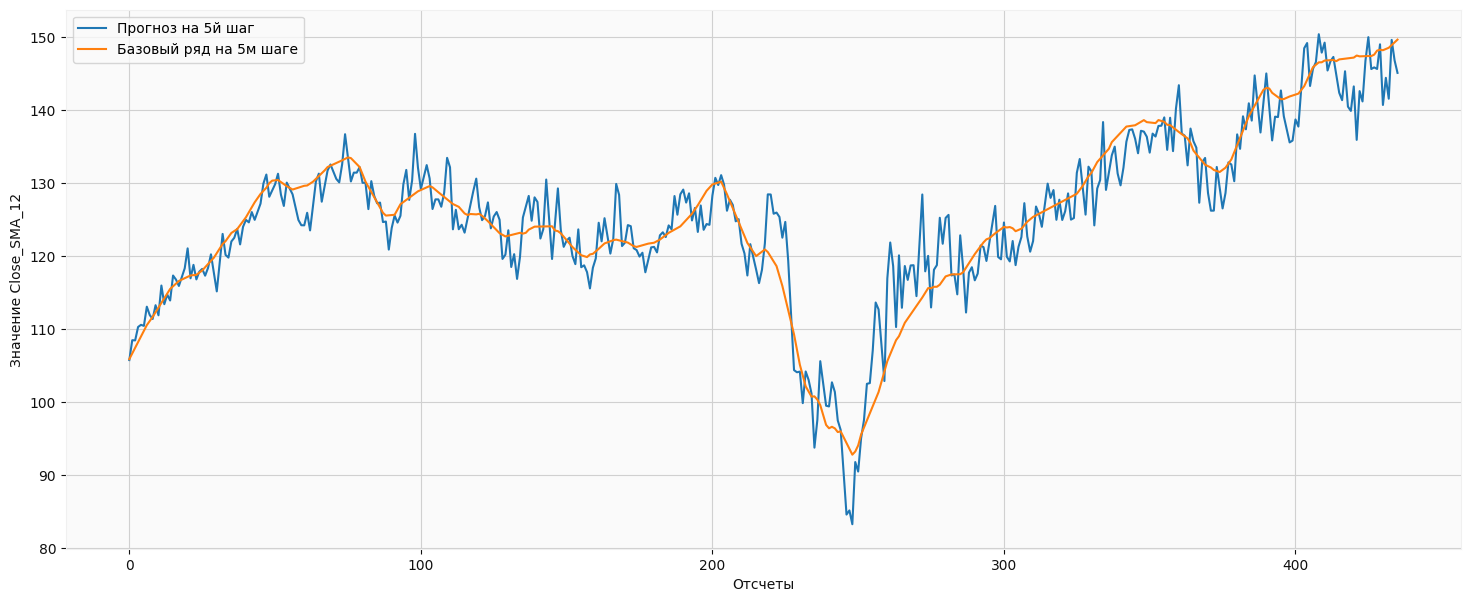

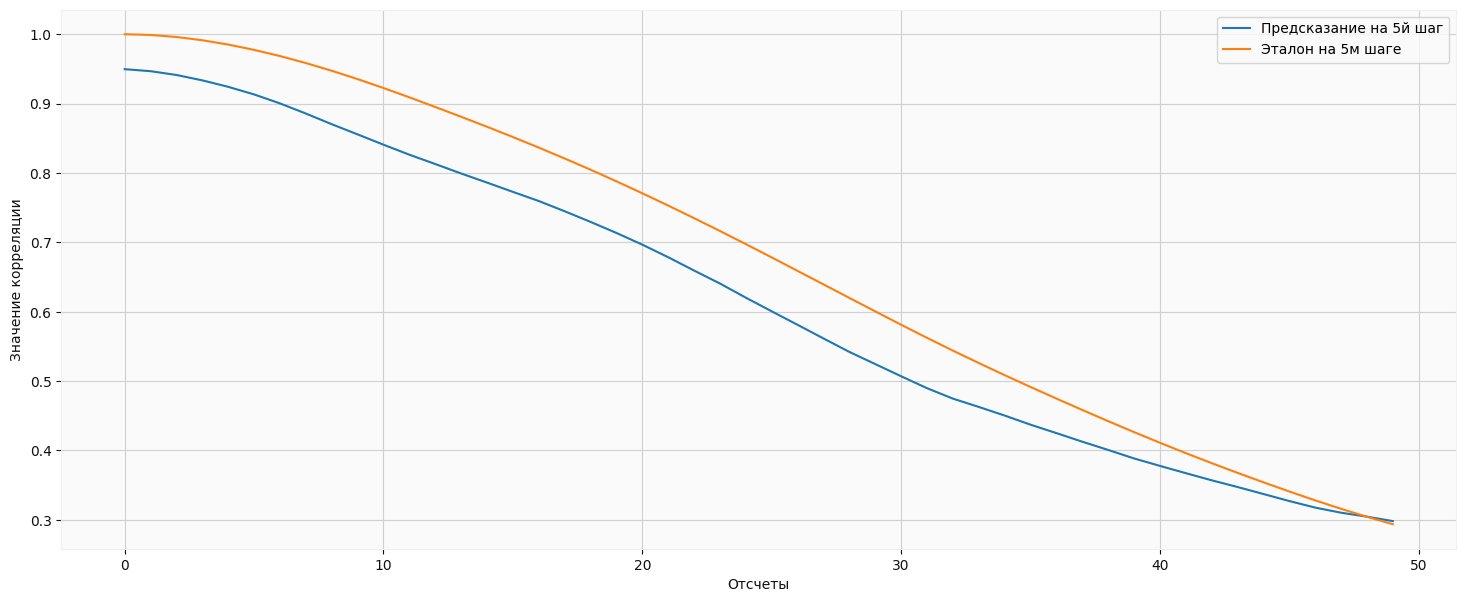

In [ ]:
# Прогнозируем данные текущей сетью

(y_pred_val, y_true_val) = get_scalepred(good_model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные
 
# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [4],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,     # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

## Тест модели на TEST данных

### готовим данные из df_test

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
TEST_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() # 
TEST_SCAILER.fit(df_test[TRAIN_COLUMNS][: - PREDICT_LAG + 1])
x_test = TEST_SCAILER.transform(df_test[TRAIN_COLUMNS][: - PREDICT_LAG + 1])
print(x_test.shape)
x_test[0]

(496, 54)


array([0.3794998 , 0.36558271, 0.38333956, 0.38989652, 0.51367929,
       0.47558087, 0.59088357, 0.51104095, 0.56506528, 0.53208139,
       0.64412938, 0.61711887, 0.58688803, 0.55825056, 0.61086695,
       0.5694536 , 0.67505492, 0.63955019, 0.73095277, 0.613883  ,
       0.68453571, 0.63455789, 0.67435139, 0.68926351, 0.59573152,
       0.61059669, 0.65703561, 0.64392983, 0.54703495, 0.53608221,
       0.63077342, 0.59966114, 0.37072748, 0.34492391, 0.36351232,
       0.36305015, 0.33924553, 0.31864276, 0.33410473, 0.33145313,
       0.37514776, 0.35433063, 0.37110097, 0.36721911, 0.33440478,
       0.31321617, 0.33434038, 0.32749462, 0.58774407, 0.55206148,
       0.60322755, 0.58824372, 0.98485678, 0.12658047])

In [ ]:
# Для подготовки y_test на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
y_test = future_sequence(df_test[PRED_PRICE], PREDICT_LAG)

# если берем логорифм
if MAKE_LOG:
  y_test = np.log(y_test)

print(y_test.shape)
y_test[0]

(496, 5)


array([5.01226174, 5.01453323, 5.01724672, 5.01997487, 5.02093209])

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
YTEST_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() # 
YTEST_SCAILER.fit(y_test)
y_test = YTEST_SCAILER.transform(y_test)

print(y_test.shape)
y_test[0]

(496, 5)


array([0.31081098, 0.31922484, 0.3292759 , 0.33938129, 0.34292693])

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
TestDataGen = TSG(x_test, y_test,        # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам 
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_test))  # Размер batch будет равен длине нашей выборки

XTEST, YTEST = [], []
for i in TestDataGen:
  XTEST.append(i[0])
  YTEST.append(i[1])

XTEST = np.array(XTEST)[0]
YTEST = np.array(YTEST)[0]
print(XTEST.shape,YTEST.shape)

(467, 29, 54) (467, 5)


### Делаем оценку test данных

15/15 [==============================] - 0s 16ms/step


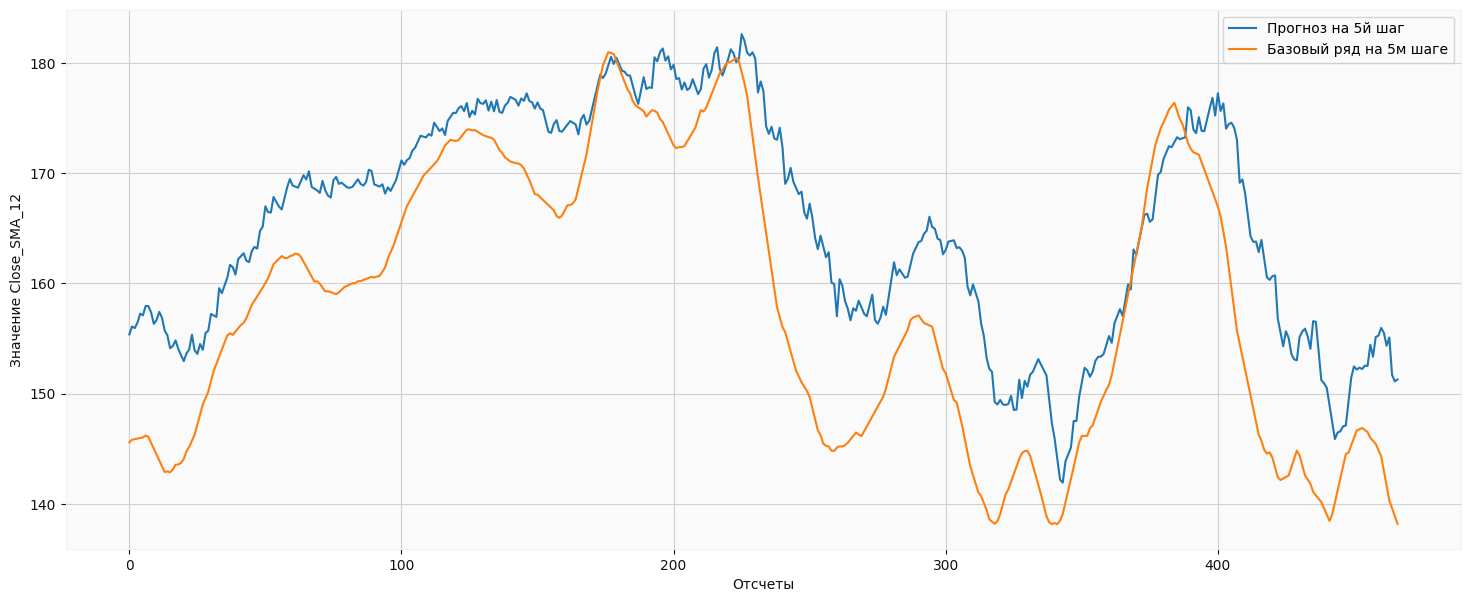

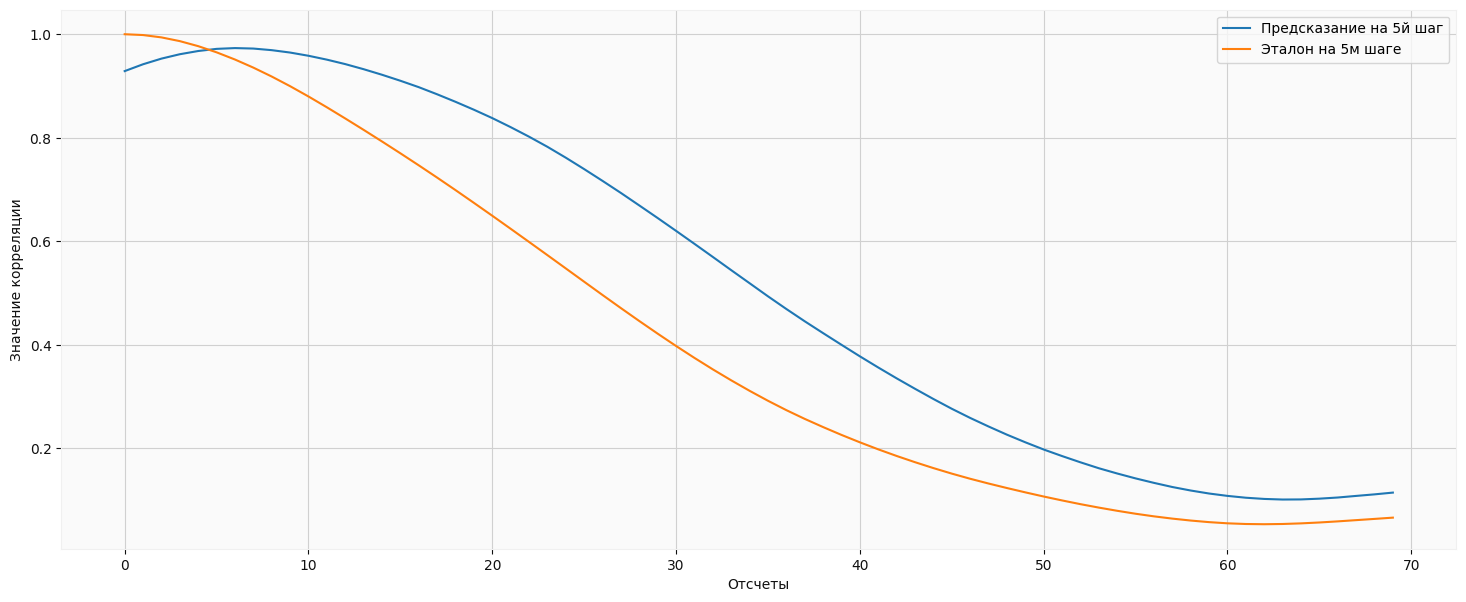

In [ ]:
# Прогнозируем данные текущей сетью

(y_pred_test, y_true_test) = get_scalepred(good_model, XTEST, YTEST, 
                                           YTEST_SCAILER) # Прогнозируем данные
 
# Отображаем графики
show_predict(0,                     # начало периода
             y_true_test.shape[0],  # конец периода
             [4],                   # по предсказанию на какие шаги отрисовываем
             y_pred_test,           # предчказанные цены
             y_true_test,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],              # по предсказанию на какие шаги отрисовываем корреляцию
          70,               # на сколько шагов предсказание
          y_pred_test,      # предчказанные цены
          y_true_test       # реальные цены
          )

### Смотрим цены и предсказываемое SMA_14

некоторые ссылки, что погли отрисовать:
- https://medium.com/@chris_42047/discover-the-awesome-power-of-mplfinance-python-tutorial-ea756975c77c
- https://github.com/matplotlib/mplfinance/issues/181
- https://stackoverflow.com/questions/70805395/how-do-i-set-the-tick-and-label-colours-in-mplfinance

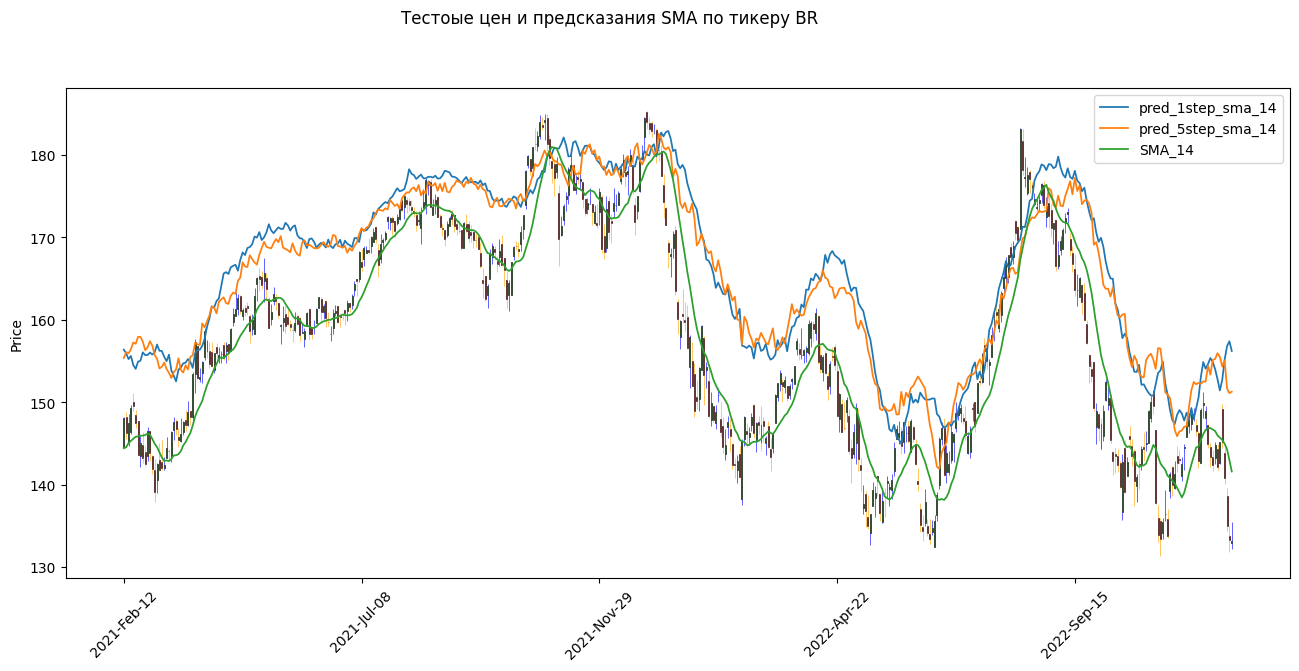

In [ ]:
# добавленые графики и названия их
add_pls = {
    'pred_1step_sma_14' : mpf.make_addplot(y_pred_test[:, 0]),
    'pred_5step_sma_14' : mpf.make_addplot(y_pred_test[:, 4]),
    'SMA_14' : mpf.make_addplot(df_test[DEPTH: - PREDICT_LAG + 1][PRED_PRICE])
}

# название всего графика
title = f'Тестоые цен и предсказания SMA по тикеру {tiker}'

# стиль отрисовки
market_colors = mpf.make_marketcolors(
                               up='green',
                               down='red',
                               edge='black',
                               wick={'up': 'blue', 'down': 'orange'},
                               volume='gray',
                               ohlc='black')
my_style = mpf.make_mpf_style(marketcolors=market_colors)

# отрисовываем графиков
fig, ax = mpf.plot(df_test[DEPTH: - PREDICT_LAG + 1], # датафрейм
                    addplot= list(add_pls.values()),  # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()

### Смотрим фрагмент

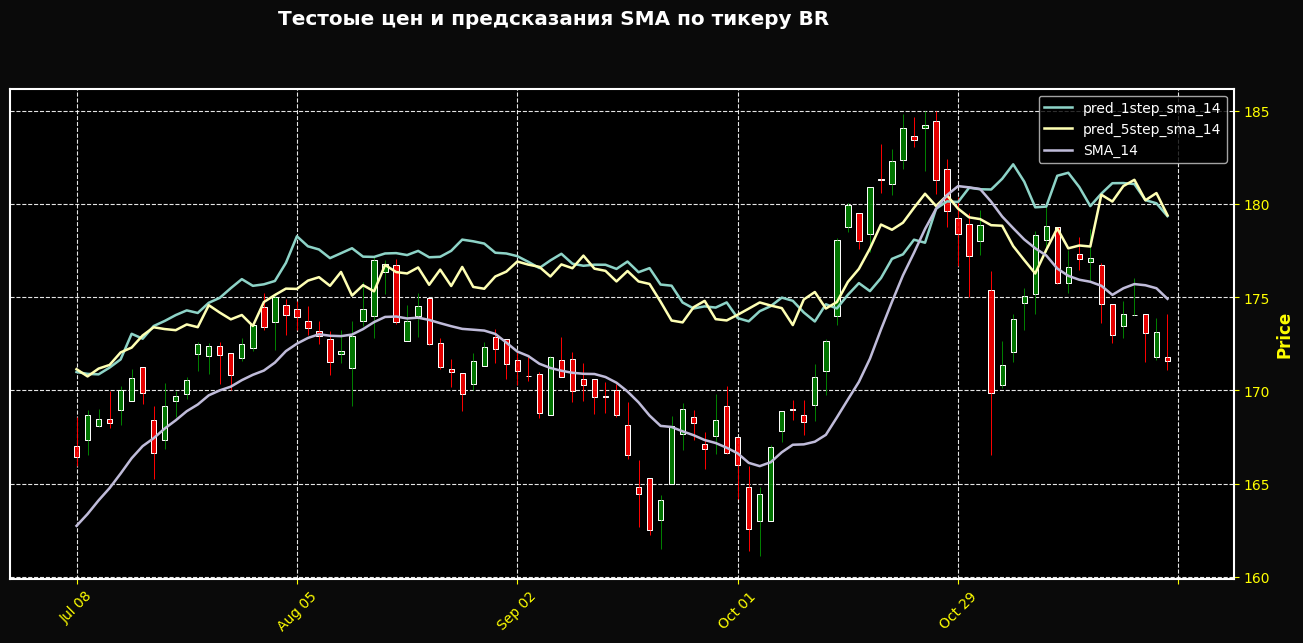

In [ ]:
start = 100
end = 200

# добавленые графики и названия их
add_pls = {
    'pred_1step_sma_14' : mpf.make_addplot(y_pred_test[:, 0][start: end]),
    'pred_5step_sma_14' : mpf.make_addplot(y_pred_test[:, 4][start: end]),
    'SMA_14' : mpf.make_addplot(df_test[DEPTH: - PREDICT_LAG + 1][PRED_PRICE][start: end])
}

# название всего графика
title = f'Тестоые цен и предсказания SMA по тикеру {tiker}'

my_style = mpf.make_mpf_style(base_mpf_style='mike',
                              base_mpl_style='dark_background',
                              marketcolors=mpf.make_marketcolors(up='g',down='r',
                                                                 edge='white',
                                                                 wick={'up':'g','down':'r'},
                                                                 volume='gray',
                                                                 ohlc='white'),
                              gridcolor='white',
                              gridstyle="--",
                              rc={'xtick.color':'yellow',
                                  'ytick.color':'yellow',
                                  'axes.labelcolor':'yellow' 
                                 }
                             )

# отрисовываем графиков
fig, ax = mpf.plot(df_test[DEPTH: - PREDICT_LAG + 1][start: end],  # датафрейм
                    addplot= list(add_pls.values()),   # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()